## 7章　ブロック崩しBreakoutの再生プログラム    

In [38]:
# パッケージのimport
import numpy as np
from collections import deque
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
from gym import spaces
from gym.spaces.box import Box


In [39]:
# パッケージのインポート
import matplotlib.pyplot as plt
%matplotlib inline


# 動画の描画関数の宣言
# 参考URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0*1, frames[0].shape[0]/72.0*1),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
 
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=20)
    anim.save('breakout.mp4')  # 動画のファイル名と保存です
    display(display_animation(anim, default_mode='loop'))
    print("--------End Animation--------")
    

In [40]:
# 実行環境の設定
# 参考：https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py

import cv2
cv2.ocl.setUseOpenCL(False)


class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        '''工夫1のNo-Operationです。リセット後適当なステップの間何もしないようにし、
        ゲーム開始の初期状態を様々にすることｆで、特定の開始状態のみで学習するのを防ぐ'''

        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(
                1, self.noop_max + 1)  # pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)


class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        '''工夫2のEpisodic Lifeです。1機失敗したときにリセットし、失敗時の状態から次を始める'''
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        '''5機とも失敗したら、本当にリセット'''
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        '''工夫3のMax and Skipです。4フレーム連続で同じ行動を実施し、最後の3、4フレームの最大値をとった画像をobsにする'''
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        '''工夫4のWarp frameです。画像サイズをNatureのDQN論文と同じ84x84の白黒にします'''
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
                                            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height),
                           interpolation=cv2.INTER_AREA)
        return frame[:, :, None]


class WrapPyTorch(gym.ObservationWrapper):
    def __init__(self, env=None):
        '''PyTorchのミニバッチのインデックス順に変更するラッパー'''
        super(WrapPyTorch, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[1], obs_shape[0]],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)


In [41]:
# 再生用の実行環境


class EpisodicLifeEnvPlay(gym.Wrapper):
    def __init__(self, env):
        '''工夫2のEpisodic Lifeです。1機失敗したときにリセットし、失敗時の状態から次を始める。
        今回は再生用に、1機失敗したときのリセット時もブロックの状態をリセットします'''

        gym.Wrapper.__init__(self, env)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        # ライフ（残機）が始め5あるが、1つでも減ると終了にする
        if self.env.unwrapped.ale.lives() < 5:
            done = True

        return obs, reward, done, info

    def reset(self, **kwargs):
        '''1回でも失敗したら完全リセット'''

        obs = self.env.reset(**kwargs)

        return obs


class MaxAndSkipEnvPlay(gym.Wrapper):
    def __init__(self, env, skip=4):
        '''工夫3のMax and Skipです。4フレーム連続で同じ行動を実施し、最後の4フレームの画像をobsにする'''
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros(
            (2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2:
                self._obs_buffer[0] = obs
            if i == self._skip - 1:
                self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break

        return obs, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


In [42]:
# 実行環境生成関数の定義

# 並列実行環境
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv


def make_env(env_id, seed, rank):
    def _thunk():
        '''_thunk()がマルチプロセス環境のSubprocVecEnvを実行するのに必要'''

        env = gym.make(env_id)
        #env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env.seed(seed + rank)  # 乱数シードの設定
        #env = EpisodicLifeEnv(env)
        env = EpisodicLifeEnvPlay(env)
        env = WarpFrame(env)
        env = WrapPyTorch(env)

        return env

    return _thunk


def make_env_play(env_id, seed, rank):
    '''再生用の実行環境'''
    env = gym.make(env_id)
    #env = NoopResetEnv(env, noop_max=30)
    #env = MaxAndSkipEnv(env, skip=4)
    env = MaxAndSkipEnvPlay(env, skip=4)
    env.seed(seed + rank)  # 乱数シードの設定
    env = EpisodicLifeEnvPlay(env)
    #env = WarpFrame(env)
    #env = WrapPyTorch(env)

    return env


In [43]:
# 定数の設定

ENV_NAME = 'BreakoutNoFrameskip-v4' 
# Breakout-v0ではなく、BreakoutNoFrameskip-v4を使用
# v0はフレームが自動的に2-4のランダムにskipされますが、今回はフレームスキップはさせないバージョンを使用
# 参考URL https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
# https://github.com/openai/gym/blob/5cb12296274020db9bb6378ce54276b31e7002da/gym/envs/__init__.py#L371
    
NUM_SKIP_FRAME = 4 # skipするframe数です
NUM_STACK_FRAME = 4  # 状態として連続的に保持するframe数です
NOOP_MAX = 30  #  reset時に何もしないフレームを挟む（No-operation）フレーム数の乱数上限です
NUM_PROCESSES = 16 #  並列して同時実行するプロセス数です
NUM_ADVANCED_STEP = 5  # 何ステップ進めて報酬和を計算するのか設定
GAMMA = 0.99  # 時間割引率

TOTAL_FRAMES=10e6  #  学習に使用する総フレーム数
NUM_UPDATES = int(TOTAL_FRAMES / NUM_ADVANCED_STEP / NUM_PROCESSES)  # ネットワークの総更新回数
# NUM_UPDATESは125,000となる


In [44]:
# A2Cの損失関数の計算のための定数設定
value_loss_coef = 0.5
entropy_coef = 0.01
max_grad_norm = 0.5

# 学習手法RMSpropの設定
lr = 7e-4
eps = 1e-5
alpha = 0.99


In [45]:
# GPUの使用の設定
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [46]:
# メモリオブジェクトの定義


class RolloutStorage(object):
    '''Advantage学習するためのメモリクラスです'''

    def __init__(self, num_steps, num_processes, obs_shape):

        self.observations = torch.zeros(
            num_steps + 1, num_processes, *obs_shape).to(device)
        # *を使うと()リストの中身を取り出す
        # obs_shape→(4,84,84)
        # *obs_shape→ 4 84 84

        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(
            num_steps, num_processes, 1).long().to(device)

        # 割引報酬和を格納
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.index = 0  # insertするインデックス

    def insert(self, current_obs, action, reward, mask):
        '''次のindexにtransitionを格納する'''
        self.observations[self.index + 1].copy_(current_obs)
        self.masks[self.index + 1].copy_(mask)
        self.rewards[self.index].copy_(reward)
        self.actions[self.index].copy_(action)

        self.index = (self.index + 1) % NUM_ADVANCED_STEP  # インデックスの更新

    def after_update(self):
        '''Advantageするstep数が完了したら、最新のものをindex0に格納'''
        self.observations[0].copy_(self.observations[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value):
        '''Advantageするステップ中の各ステップの割引報酬和を計算する'''

        # 注意：5step目から逆向きに計算しています
        # 注意：5step目はAdvantage1となる。4ステップ目はAdvantage2となる。・・・
        self.returns[-1] = next_value
        for ad_step in reversed(range(self.rewards.size(0))):
            self.returns[ad_step] = self.returns[ad_step + 1] * \
                GAMMA * self.masks[ad_step + 1] + self.rewards[ad_step]


In [47]:
# A2Cのディープ・ニューラルネットワークの構築


def init(module, gain):
    '''層の結合パラメータを初期化する関数を定義'''
    nn.init.orthogonal_(module.weight.data, gain=gain)
    nn.init.constant_(module.bias.data, 0)
    return module


class Flatten(nn.Module):
    '''コンボリューション層の出力画像を1次元に変換する層を定義'''

    def forward(self, x):
        return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self, n_out):
        super(Net, self).__init__()

        # 結合パラメータの初期化関数
        def init_(module): return init(
            module, gain=nn.init.calculate_gain('relu'))

        # コンボリューション層の定義
        self.conv = nn.Sequential(
            # 画像サイズの変化84*84→20*20
            init_(nn.Conv2d(NUM_STACK_FRAME, 32, kernel_size=8, stride=4)),
            # stackするflameは4画像なのでinput=NUM_STACK_FRAME=4である、出力は32とする、
            # sizeの計算  size = (Input_size - Kernel_size + 2*Padding_size)/ Stride_size + 1

            nn.ReLU(),
            # 画像サイズの変化20*20→9*9
            init_(nn.Conv2d(32, 64, kernel_size=4, stride=2)),
            nn.ReLU(),
            init_(nn.Conv2d(64, 64, kernel_size=3, stride=1)),  # 画像サイズの変化9*9→7*7
            nn.ReLU(),
            Flatten(),  # 画像形式を1次元に変換
            init_(nn.Linear(64 * 7 * 7, 512)),  # 64枚の7×7の画像を、512次元のoutputへ
            nn.ReLU()
        )

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=1.0)

        # Criticの定義
        self.critic = init_(nn.Linear(512, 1))  # 状態価値なので出力は1つ

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=0.01)

        # Actorの定義
        self.actor = init_(nn.Linear(512, n_out))  # 行動を決めるので出力は行動の種類数

        # ネットワークを訓練モードに設定
        self.train()

    def forward(self, x):
        '''ネットワークのフォワード計算を定義します'''
        input = x / 255.0  # 画像のピクセル値0-255を0-1に正規化する
        conv_output = self.conv(input)  # Convolution層の計算
        critic_output = self.critic(conv_output)  # 状態価値の計算
        actor_output = self.actor(conv_output)  # 行動の計算

        return critic_output, actor_output

    def act(self, x):
        '''状態xから行動を確率的に求めます'''
        value, actor_output = self(x)
        probs = F.softmax(actor_output, dim=1)    # dim=1で行動の種類方向に計算
        action = probs.multinomial(num_samples=1)

        return action

    def get_value(self, x):
        '''状態xから状態価値を求めます'''
        value, actor_output = self(x)

        return value

    def evaluate_actions(self, x, actions):
        '''状態xから状態価値、実際の行動actionsのlog確率とエントロピーを求めます'''
        value, actor_output = self(x)

        log_probs = F.log_softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        action_log_probs = log_probs.gather(1, actions)  # 実際の行動のlog_probsを求める

        probs = F.softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        dist_entropy = -(log_probs * probs).sum(-1).mean()

        return value, action_log_probs, dist_entropy


In [48]:
# エージェントが持つ頭脳となるクラスを定義、全エージェントで共有する


class Brain(object):
    def __init__(self, actor_critic):

        self.actor_critic = actor_critic  # actor_criticはクラスNetのディープ・ニューラルネットワーク

        # 結合パラメータをロードする場合
        filename = 'weight_end.pth'
        #filename = 'weight_112500.pth'
        param = torch.load(filename, map_location='cpu')
        self.actor_critic.load_state_dict(param)

        # パラメータ更新の勾配法の設定
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr=lr, eps=eps, alpha=alpha)

    def update(self, rollouts):
        '''advanced計算した5つのstepの全てを使って更新します'''
        obs_shape = rollouts.observations.size()[2:]  # torch.Size([4, 84, 84])
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES

        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        # 注意：各変数のサイズ
        # rollouts.observations[:-1].view(-1, *obs_shape) torch.Size([80, 4, 84, 84])
        # rollouts.actions.view(-1, 1) torch.Size([80, 1])
        # values torch.Size([80, 1])
        # action_log_probs torch.Size([80, 1])
        # dist_entropy torch.Size([])

        values = values.view(num_steps, num_processes,
                             1)  # torch.Size([5, 16, 1])
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values  # torch.Size([5, 16, 1])
        value_loss = advantages.pow(2).mean()

        action_gain = (advantages.detach() * action_log_probs).mean()
        # detachしてadvantagesを定数として扱う

        total_loss = (value_loss * value_loss_coef -
                      action_gain - dist_entropy * entropy_coef)

        self.optimizer.zero_grad()  # 勾配をリセット
        total_loss.backward()  # バックプロパゲーションを計算
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        #  一気に結合パラメータが変化しすぎないように、勾配の大きさは最大0.5までにする

        self.optimizer.step()  # 結合パラメータを更新


In [49]:
# Breakoutを実行する環境のクラス

NUM_PROCESSES = 1


class Environment:
    def run(self):

        # seedの設定
        seed_num = 1
        torch.manual_seed(seed_num)
        if use_cuda:
            torch.cuda.manual_seed(seed_num)

        # 実行環境を構築
        torch.set_num_threads(seed_num)
        envs = [make_env(ENV_NAME, seed_num, i) for i in range(NUM_PROCESSES)]
        envs = SubprocVecEnv(envs)  # マルチプロセスの実行環境にする

        # 全エージェントが共有して持つ頭脳Brainを生成
        n_out = envs.action_space.n  # 行動の種類は4
        actor_critic = Net(n_out).to(device)  # GPUへ
        global_brain = Brain(actor_critic)

        # 格納用変数の生成
        obs_shape = envs.observation_space.shape  # (1, 84, 84)
        obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
                     *obs_shape[1:])  # (4, 84, 84)
        # torch.Size([16, 4, 84, 84])
        current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
        rollouts = RolloutStorage(
            NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
        episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
        final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

        # 初期状態の開始
        obs = envs.reset()
        obs = torch.from_numpy(obs).float()  # torch.Size([16, 1, 84, 84])
        current_obs[:, -1:] = obs  # flameの4番目に最新のobsを格納

        # advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
        rollouts.observations[0].copy_(current_obs)

        # 描画用の環境（再生用に追加）
        env_play = make_env_play(ENV_NAME, seed_num, 0)
        obs_play = env_play.reset()

        # 動画にするために画像を格納する変数（再生用に追加）
        frames = []
        main_end = False

        # 実行ループ
        for j in tqdm(range(NUM_UPDATES)):

            # 報酬が基準を超えたら終わりにする（再生用に追加）
            if main_end:
                break

            # advanced学習するstep数ごとに計算
            for step in range(NUM_ADVANCED_STEP):

                # 行動を求める
                with torch.no_grad():
                    action = actor_critic.act(rollouts.observations[step])

                cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに

                # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
                obs, reward, done, info = envs.step(cpu_actions)

                # 報酬をtensorに変換し、試行の総報酬に足す
                # sizeが(16,)になっているのを(16, 1)に変換
                reward = np.expand_dims(np.stack(reward), 1)
                reward = torch.from_numpy(reward).float()
                episode_rewards += reward

                # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
                masks = torch.FloatTensor(
                    [[0.0] if done_ else [1.0] for done_ in done])

                # 最後の試行の総報酬を更新する
                final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
                # 継続中は0を足す、done時にはepisode_rewardsを足す
                final_rewards += (1 - masks) * episode_rewards

                # 画像を取得する(再生用に追加）
                obs_play, reward_play, _, _ = env_play.step(cpu_actions[0])
                frames.append(obs_play)  # 変換した画像を保存
                if done[0]:  # 並列環境の1つ目が終了した場合
                    print(episode_rewards[0][0].numpy())  # 報酬

                    # 報酬が300を超えたら終わりにする
                    if (episode_rewards[0][0].numpy()) > 300:
                        main_end = True
                        break
                    else:
                        obs_view = env_play.reset()
                        frames = []  # 保存した画像をリセット

                # 試行の総報酬を更新する
                episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に

                # masksをGPUへ
                masks = masks.to(device)

                # 現在の状態をdone時には全部0にする
                # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
                current_obs *= masks.unsqueeze(2).unsqueeze(2)

                # frameをstackする
                # torch.Size([16, 1, 84, 84])
                obs = torch.from_numpy(obs).float()
                current_obs[:, :-1] = current_obs[:, 1:]  # 0～2番目に1～3番目を上書き
                current_obs[:, -1:] = obs  # 4番目に最新のobsを格納

                # メモリオブジェクトに今stepのtransitionを挿入
                rollouts.insert(current_obs, action.data, reward, masks)

            # advancedのfor loop終了

            # advancedした最終stepの状態から予想する状態価値を計算
            with torch.no_grad():
                next_value = actor_critic.get_value(
                    rollouts.observations[-1]).detach()

            # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
            rollouts.compute_returns(next_value)

            # ネットワークとrolloutの更新
            # global_brain.update(rollouts)
            rollouts.after_update()

        # 実行ループ終わり
        display_frames_as_gif(frames)  # 動画の保存と再生




  0%|          | 0/125000 [00:00<?, ?it/s]

  0%|          | 5/125000 [00:00<49:26, 42.13it/s]

  0%|          | 10/125000 [00:00<48:47, 42.70it/s]

  0%|          | 15/125000 [00:00<47:59, 43.41it/s]

  0%|          | 20/125000 [00:00<47:38, 43.72it/s]

  0%|          | 25/125000 [00:00<47:04, 44.25it/s]

  0%|          | 30/125000 [00:00<46:43, 44.58it/s]

  0%|          | 35/125000 [00:00<46:28, 44.82it/s]

  0%|          | 40/125000 [00:00<46:36, 44.68it/s]

  0%|          | 45/125000 [00:01<48:00, 43.38it/s]

  0%|          | 50/125000 [00:01<47:26, 43.89it/s]

  0%|          | 55/125000 [00:01<46:32, 44.74it/s]

  0%|          | 60/125000 [00:01<46:09, 45.11it/s]

  0%|          | 65/125000 [00:01<46:23, 44.89it/s]

  0%|          | 70/125000 [00:01<47:02, 44.26it/s]

  0%|          | 75/125000 [00:01<46:53, 44.40it/s]

  0%|          | 80/125000 [00:01<46:28, 44.80it/s]

  0%|          | 85/125000 [00:01<46:48, 44.47it/s]

  0%|          | 90/125000 [00:02<48:05, 43.29it/s]

 

259.0




  0%|          | 260/125000 [00:05<52:03, 39.93it/s]

  0%|          | 265/125000 [00:06<51:17, 40.53it/s]

  0%|          | 270/125000 [00:06<50:46, 40.94it/s]

  0%|          | 275/125000 [00:06<50:51, 40.87it/s]

  0%|          | 280/125000 [00:06<50:49, 40.90it/s]

  0%|          | 285/125000 [00:06<50:46, 40.94it/s]

  0%|          | 290/125000 [00:06<50:59, 40.76it/s]

  0%|          | 295/125000 [00:06<51:43, 40.18it/s]

  0%|          | 300/125000 [00:06<52:07, 39.87it/s]

  0%|          | 305/125000 [00:07<51:32, 40.32it/s]

  0%|          | 310/125000 [00:07<51:39, 40.23it/s]

  0%|          | 315/125000 [00:07<51:07, 40.65it/s]

  0%|          | 320/125000 [00:07<50:47, 40.92it/s]

  0%|          | 325/125000 [00:07<50:25, 41.21it/s]

  0%|          | 330/125000 [00:07<50:42, 40.97it/s]

  0%|          | 335/125000 [00:07<50:32, 41.11it/s]

  0%|          | 340/125000 [00:07<51:02, 40.70it/s]

  0%|          | 345/125000 [00:08<50:52, 40.83it/s]

  0%|          | 350/12500

24.0




  0%|          | 380/125000 [00:08<52:00, 39.93it/s]

  0%|          | 385/125000 [00:09<51:56, 39.99it/s]

  0%|          | 390/125000 [00:09<51:31, 40.31it/s]

  0%|          | 395/125000 [00:09<51:20, 40.44it/s]

  0%|          | 400/125000 [00:09<51:12, 40.55it/s]

  0%|          | 405/125000 [00:09<50:52, 40.82it/s]

  0%|          | 410/125000 [00:09<50:08, 41.41it/s]

5.0




  0%|          | 415/125000 [00:09<52:05, 39.86it/s]

  0%|          | 420/125000 [00:09<51:44, 40.12it/s]

  0%|          | 425/125000 [00:10<51:07, 40.61it/s]

  0%|          | 430/125000 [00:10<51:15, 40.51it/s]

2.0




  0%|          | 435/125000 [00:10<52:39, 39.43it/s]

  0%|          | 439/125000 [00:10<52:34, 39.48it/s]

  0%|          | 444/125000 [00:10<51:57, 39.95it/s]

  0%|          | 449/125000 [00:10<51:31, 40.29it/s]

  0%|          | 454/125000 [00:10<51:13, 40.53it/s]

  0%|          | 459/125000 [00:10<51:04, 40.64it/s]

  0%|          | 464/125000 [00:11<50:58, 40.72it/s]

  0%|          | 469/125000 [00:11<50:47, 40.87it/s]

  0%|          | 474/125000 [00:11<50:54, 40.76it/s]

  0%|          | 479/125000 [00:11<50:37, 40.99it/s]

  0%|          | 484/125000 [00:11<50:23, 41.19it/s]

  0%|          | 489/125000 [00:11<50:13, 41.31it/s]

  0%|          | 494/125000 [00:11<50:15, 41.29it/s]

  0%|          | 499/125000 [00:11<50:38, 40.98it/s]

  0%|          | 504/125000 [00:11<50:28, 41.11it/s]

  0%|          | 509/125000 [00:12<50:40, 40.95it/s]

  0%|          | 514/125000 [00:12<50:37, 40.99it/s]

  0%|          | 519/125000 [00:12<50:34, 41.02it/s]

  0%|          | 524/12500

144.0




  1%|          | 724/125000 [00:17<54:16, 38.16it/s]

  1%|          | 729/125000 [00:17<53:36, 38.63it/s]

  1%|          | 733/125000 [00:17<53:37, 38.62it/s]

  1%|          | 738/125000 [00:17<52:39, 39.33it/s]

  1%|          | 742/125000 [00:17<52:34, 39.40it/s]

  1%|          | 747/125000 [00:17<51:47, 39.99it/s]

  1%|          | 752/125000 [00:18<51:30, 40.20it/s]

  1%|          | 757/125000 [00:18<51:30, 40.20it/s]

  1%|          | 762/125000 [00:18<51:10, 40.47it/s]

  1%|          | 767/125000 [00:18<50:53, 40.68it/s]

  1%|          | 772/125000 [00:18<50:28, 41.02it/s]

  1%|          | 777/125000 [00:18<50:13, 41.22it/s]

  1%|          | 782/125000 [00:18<49:54, 41.48it/s]

  1%|          | 787/125000 [00:18<49:47, 41.57it/s]

  1%|          | 792/125000 [00:19<50:25, 41.06it/s]

  1%|          | 797/125000 [00:19<50:10, 41.26it/s]

  1%|          | 802/125000 [00:19<50:08, 41.28it/s]

  1%|          | 807/125000 [00:19<49:41, 41.66it/s]

  1%|          | 812/12500

24.0




  1%|          | 842/125000 [00:20<52:53, 39.13it/s]

  1%|          | 847/125000 [00:20<51:54, 39.86it/s]

  1%|          | 852/125000 [00:20<51:26, 40.22it/s]

  1%|          | 857/125000 [00:20<50:45, 40.77it/s]

  1%|          | 862/125000 [00:20<50:23, 41.06it/s]

  1%|          | 867/125000 [00:20<50:06, 41.29it/s]

  1%|          | 872/125000 [00:20<49:56, 41.42it/s]

  1%|          | 877/125000 [00:21<49:58, 41.39it/s]

  1%|          | 882/125000 [00:21<50:35, 40.89it/s]

  1%|          | 887/125000 [00:21<50:38, 40.85it/s]

  1%|          | 892/125000 [00:21<50:47, 40.72it/s]

  1%|          | 897/125000 [00:21<50:27, 40.99it/s]

  1%|          | 902/125000 [00:21<50:22, 41.05it/s]

  1%|          | 907/125000 [00:21<50:02, 41.33it/s]

  1%|          | 912/125000 [00:21<50:22, 41.06it/s]

  1%|          | 917/125000 [00:22<50:26, 41.00it/s]

  1%|          | 922/125000 [00:22<50:50, 40.67it/s]

  1%|          | 927/125000 [00:22<51:13, 40.36it/s]

  1%|          | 932/12500

121.0




  1%|          | 1123/125000 [00:27<52:39, 39.21it/s]

  1%|          | 1128/125000 [00:27<52:25, 39.38it/s]

  1%|          | 1133/125000 [00:27<51:35, 40.02it/s]

  1%|          | 1138/125000 [00:27<51:03, 40.43it/s]

  1%|          | 1143/125000 [00:27<50:32, 40.84it/s]

  1%|          | 1148/125000 [00:27<50:42, 40.71it/s]

  1%|          | 1153/125000 [00:27<50:28, 40.90it/s]

  1%|          | 1158/125000 [00:28<50:07, 41.18it/s]

  1%|          | 1163/125000 [00:28<50:38, 40.76it/s]

  1%|          | 1168/125000 [00:28<50:46, 40.65it/s]

  1%|          | 1173/125000 [00:28<50:21, 40.98it/s]

  1%|          | 1178/125000 [00:28<50:33, 40.81it/s]

  1%|          | 1183/125000 [00:28<50:14, 41.08it/s]

  1%|          | 1188/125000 [00:28<50:28, 40.88it/s]

  1%|          | 1193/125000 [00:28<49:57, 41.30it/s]

  1%|          | 1198/125000 [00:29<50:27, 40.89it/s]

11.0




  1%|          | 1203/125000 [00:29<51:47, 39.84it/s]

  1%|          | 1208/125000 [00:29<51:26, 40.11it/s]

  1%|          | 1213/125000 [00:29<51:22, 40.15it/s]

  1%|          | 1218/125000 [00:29<50:50, 40.57it/s]

  1%|          | 1223/125000 [00:29<50:47, 40.61it/s]

  1%|          | 1228/125000 [00:29<51:06, 40.36it/s]

  1%|          | 1233/125000 [00:29<50:50, 40.57it/s]

  1%|          | 1238/125000 [00:30<50:23, 40.93it/s]

  1%|          | 1243/125000 [00:30<50:12, 41.08it/s]

  1%|          | 1248/125000 [00:30<50:19, 40.98it/s]

  1%|          | 1253/125000 [00:30<50:02, 41.22it/s]

  1%|          | 1258/125000 [00:30<49:49, 41.39it/s]

  1%|          | 1263/125000 [00:30<50:11, 41.09it/s]

  1%|          | 1268/125000 [00:30<49:55, 41.30it/s]

  1%|          | 1273/125000 [00:30<50:00, 41.24it/s]

  1%|          | 1278/125000 [00:31<49:33, 41.61it/s]

  1%|          | 1283/125000 [00:31<49:37, 41.55it/s]

  1%|          | 1288/125000 [00:31<49:34, 41.60it/s]

  1%|   

74.0




  1%|          | 1418/125000 [00:34<54:09, 38.03it/s]

  1%|          | 1422/125000 [00:34<53:55, 38.19it/s]

  1%|          | 1427/125000 [00:34<52:32, 39.19it/s]

  1%|          | 1432/125000 [00:34<51:31, 39.98it/s]

  1%|          | 1437/125000 [00:34<51:35, 39.92it/s]

2.0




  1%|          | 1442/125000 [00:35<52:59, 38.87it/s]

  1%|          | 1446/125000 [00:35<52:38, 39.12it/s]

  1%|          | 1450/125000 [00:35<52:22, 39.32it/s]

  1%|          | 1455/125000 [00:35<51:42, 39.82it/s]

  1%|          | 1460/125000 [00:35<51:30, 39.98it/s]

  1%|          | 1465/125000 [00:35<51:03, 40.32it/s]

  1%|          | 1470/125000 [00:35<50:13, 40.99it/s]

  1%|          | 1475/125000 [00:35<50:03, 41.12it/s]

  1%|          | 1480/125000 [00:36<49:57, 41.21it/s]

  1%|          | 1485/125000 [00:36<50:14, 40.98it/s]

  1%|          | 1490/125000 [00:36<50:41, 40.61it/s]

  1%|          | 1495/125000 [00:36<50:50, 40.49it/s]

  1%|          | 1500/125000 [00:36<51:08, 40.25it/s]

  1%|          | 1505/125000 [00:36<50:48, 40.50it/s]

  1%|          | 1510/125000 [00:36<50:20, 40.88it/s]

  1%|          | 1515/125000 [00:36<49:59, 41.17it/s]

  1%|          | 1520/125000 [00:37<50:04, 41.10it/s]

  1%|          | 1525/125000 [00:37<49:35, 41.50it/s]

  1%|   

54.0




  1%|▏         | 1620/125000 [00:39<53:10, 38.67it/s]

  1%|▏         | 1625/125000 [00:39<52:10, 39.41it/s]

  1%|▏         | 1630/125000 [00:39<51:29, 39.93it/s]

  1%|▏         | 1635/125000 [00:39<51:33, 39.88it/s]

  1%|▏         | 1640/125000 [00:39<51:05, 40.24it/s]

  1%|▏         | 1645/125000 [00:40<51:52, 39.63it/s]

  1%|▏         | 1650/125000 [00:40<51:34, 39.86it/s]

  1%|▏         | 1654/125000 [00:40<51:55, 39.59it/s]

  1%|▏         | 1658/125000 [00:40<52:20, 39.27it/s]

  1%|▏         | 1662/125000 [00:40<52:38, 39.06it/s]

  1%|▏         | 1666/125000 [00:40<52:40, 39.02it/s]

  1%|▏         | 1671/125000 [00:40<51:30, 39.90it/s]

  1%|▏         | 1676/125000 [00:40<51:18, 40.06it/s]

  1%|▏         | 1681/125000 [00:41<50:36, 40.62it/s]

  1%|▏         | 1686/125000 [00:41<50:21, 40.81it/s]

  1%|▏         | 1691/125000 [00:41<50:15, 40.89it/s]

  1%|▏         | 1696/125000 [00:41<50:10, 40.95it/s]

  1%|▏         | 1701/125000 [00:41<50:07, 40.99it/s]

  1%|▏  

402.0



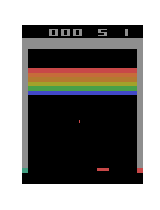
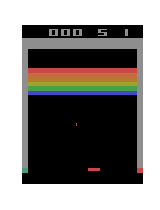
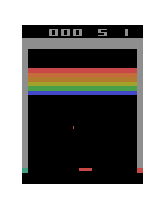
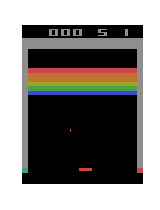
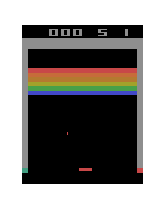
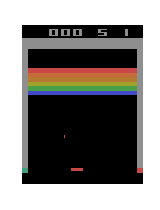
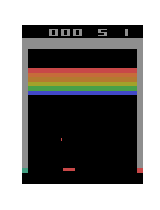
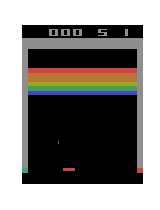
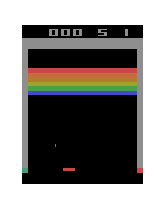
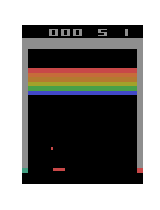
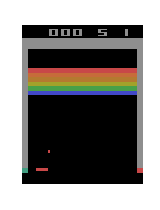
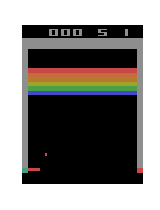
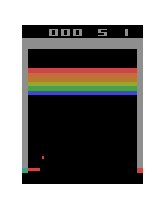
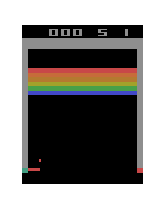
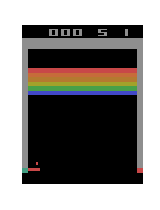
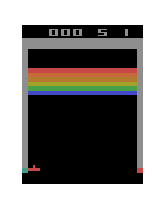
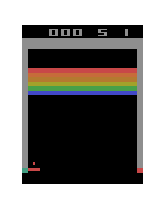
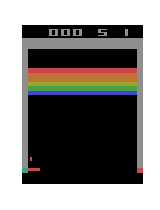
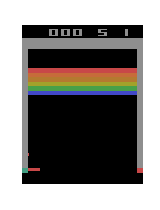
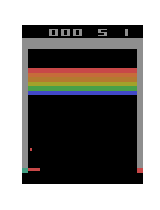
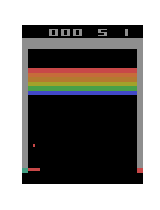
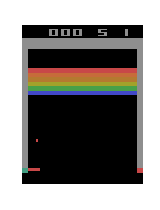
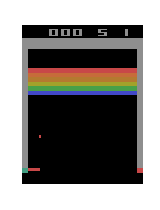
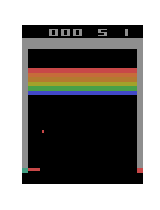
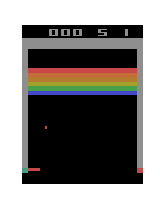
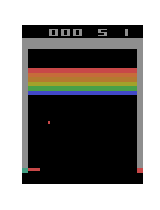
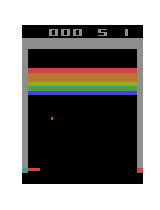
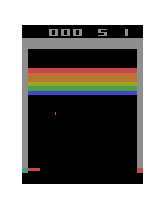
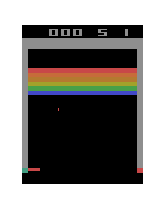
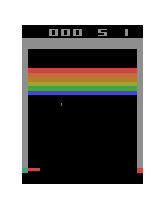
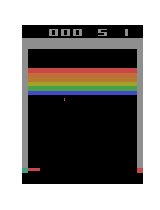
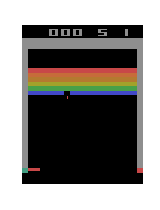
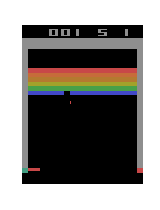
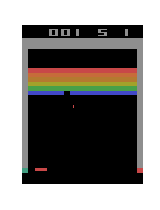
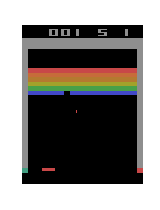
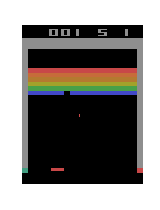
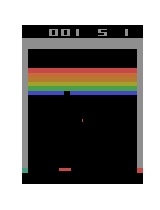
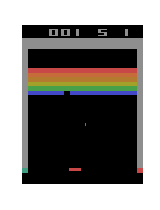
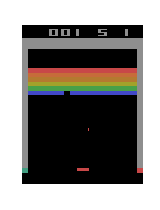
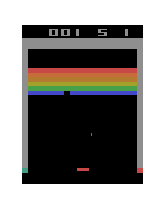
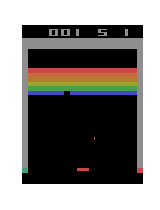
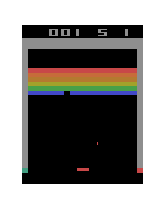
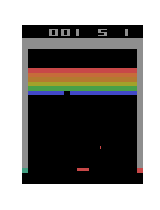
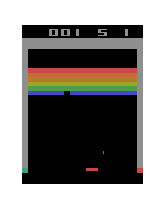
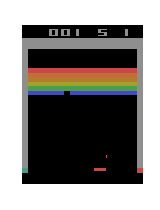
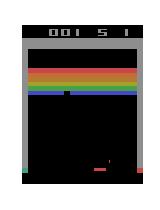
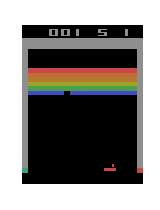
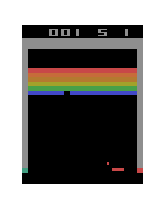
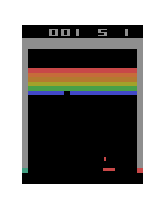
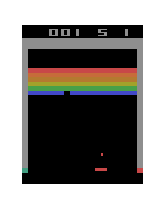
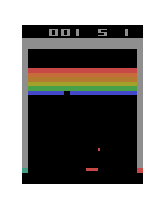
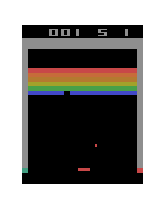
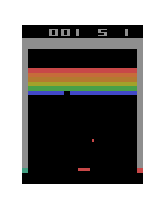
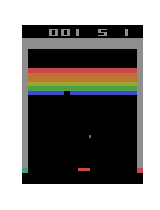
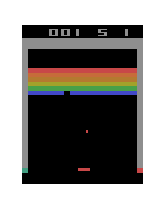
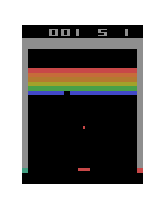
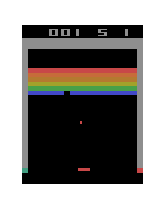
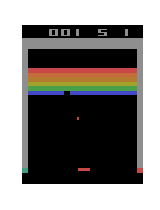
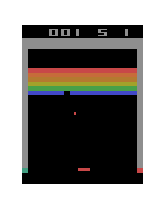
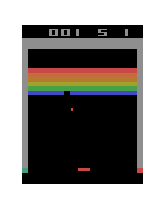
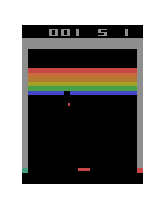
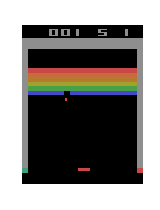
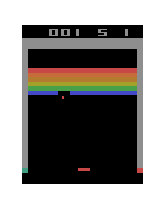
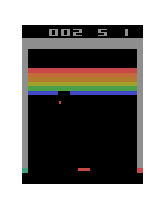
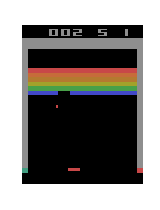
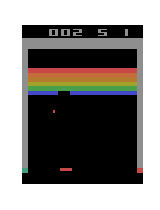
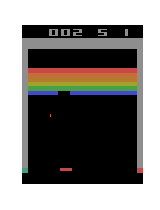
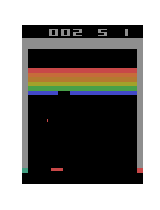
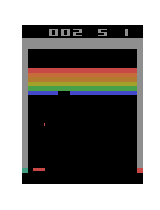
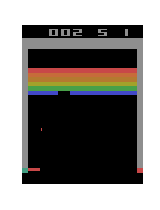
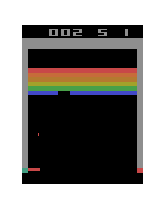
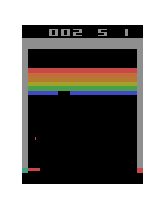
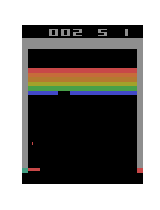
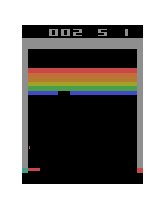
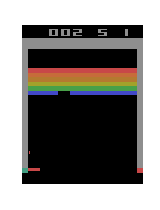
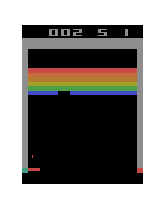
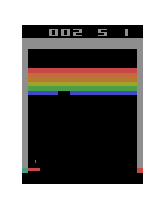
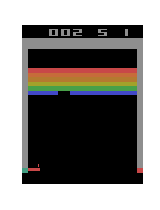
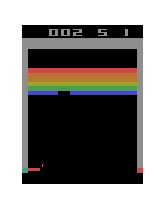
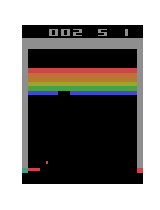
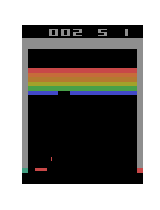
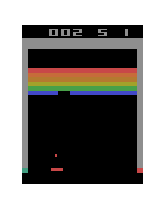
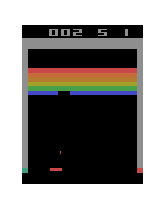
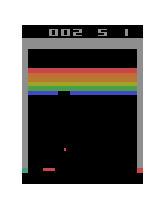
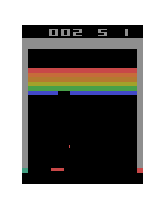
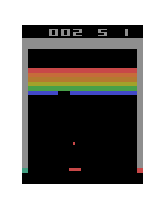
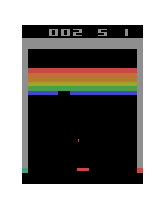
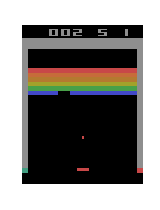
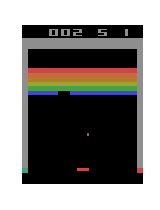
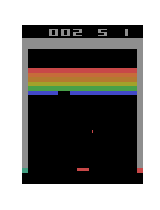
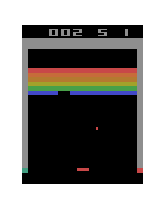
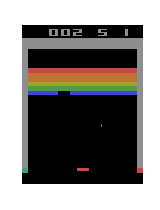
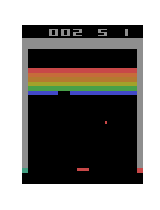
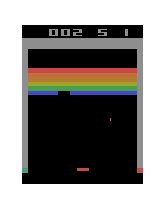
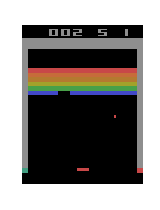
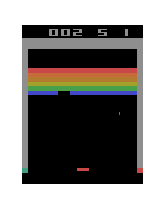
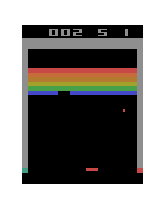
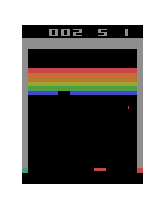
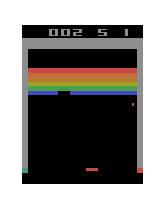
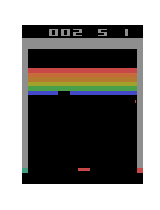
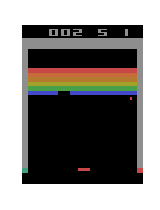
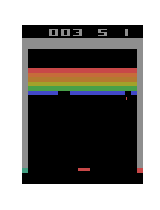
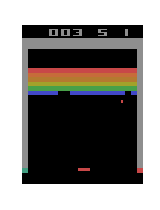
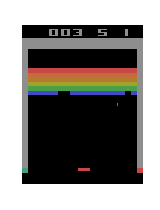
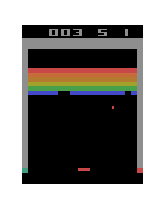
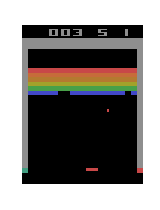
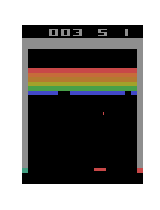
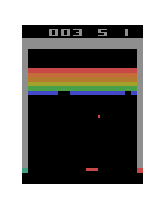
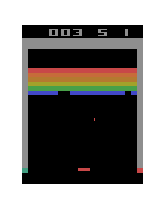
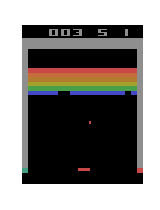
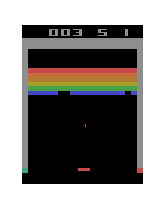
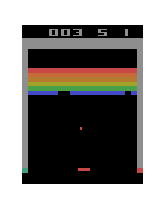
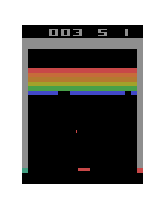
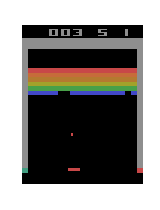
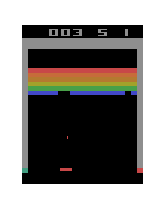
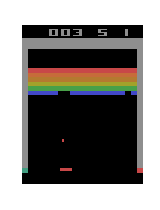
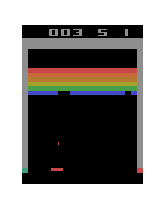
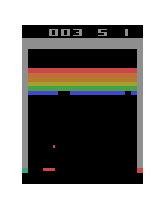
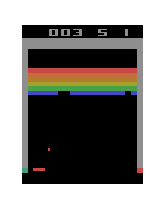
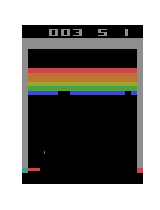
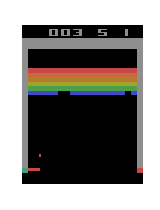
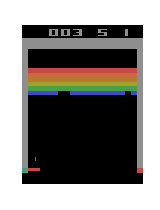
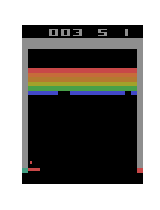
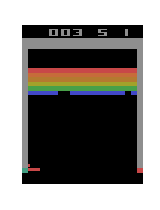
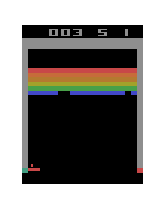
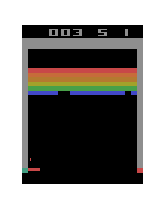
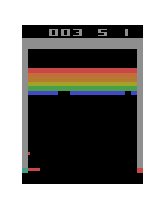
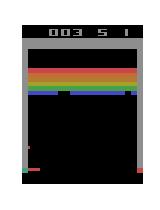
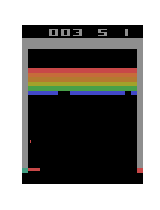
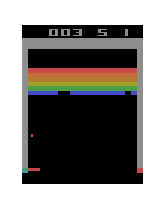
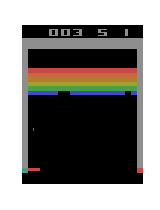
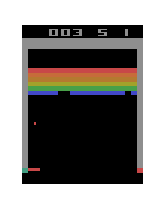
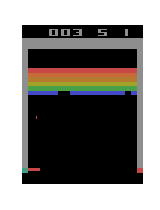
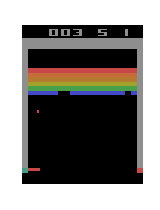
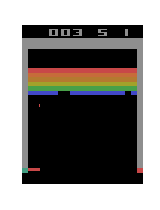
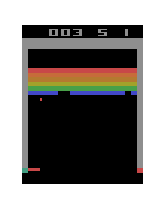
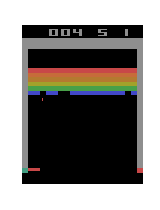
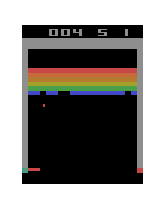
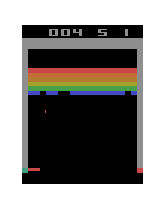
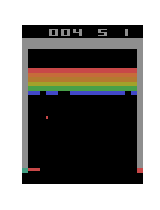
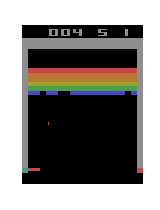
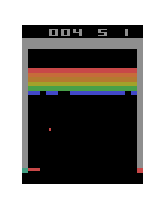
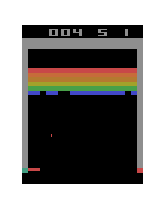
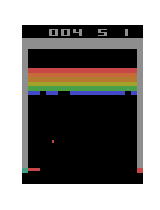
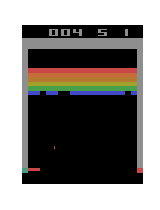
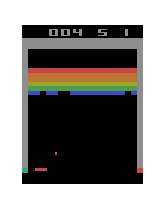
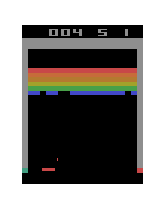
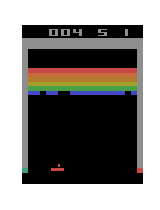
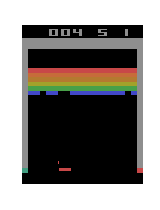
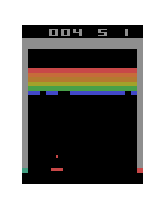
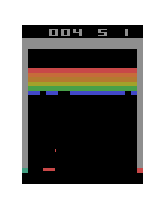
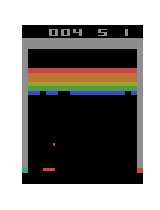
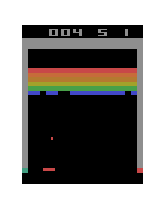
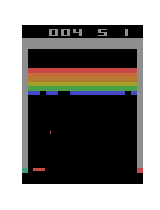
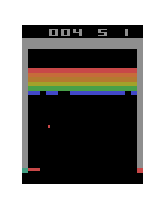
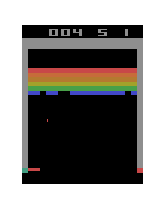
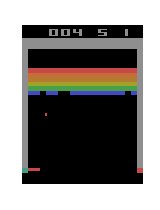
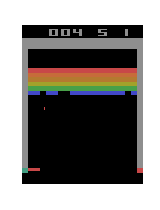
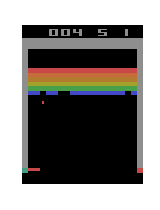
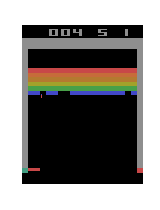
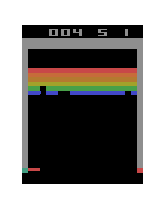
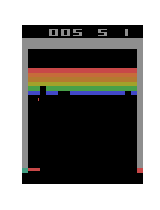
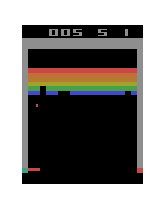
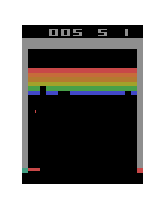
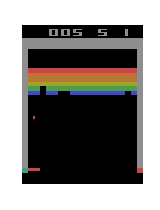
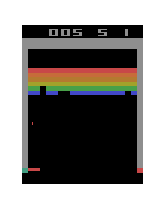
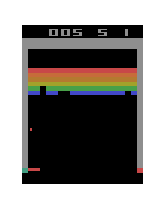
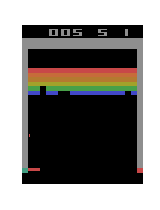
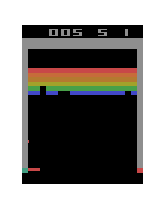
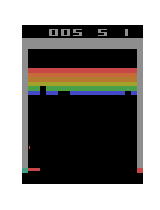
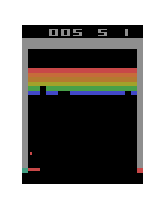
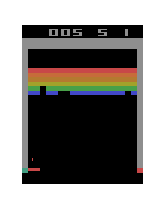
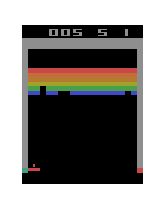
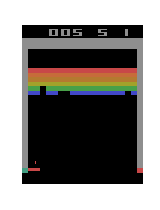
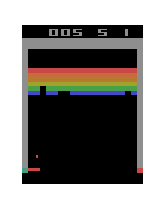
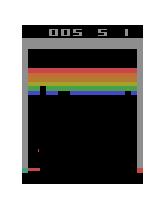
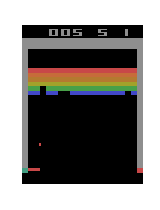
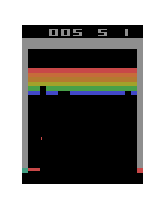
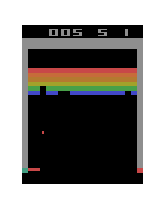
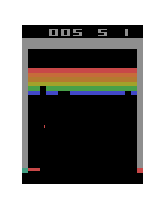
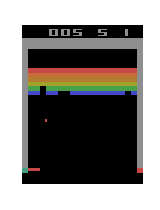
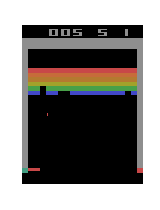
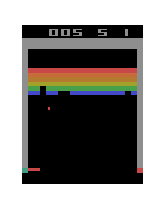
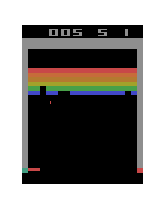
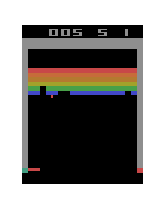
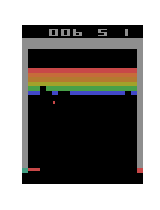
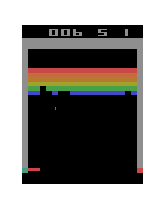
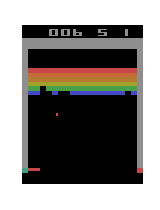
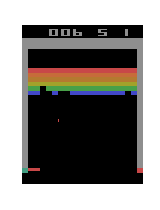
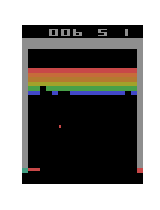
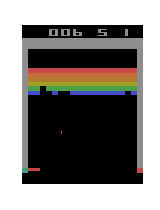
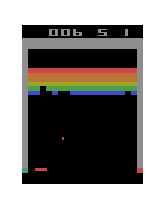
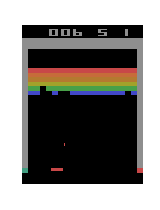
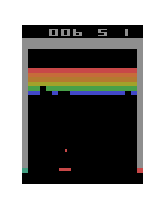
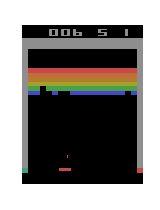
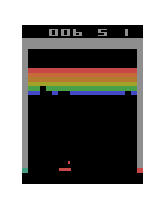
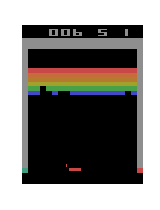
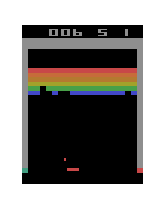
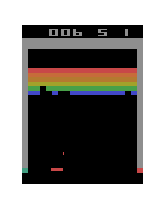
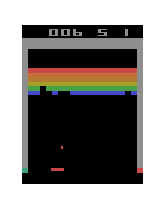
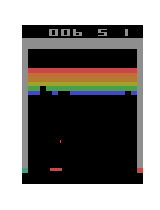
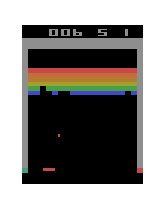
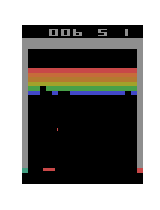
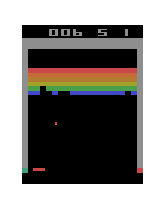
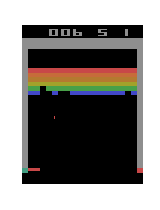
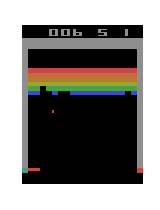
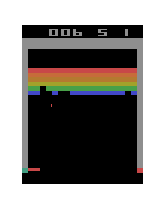
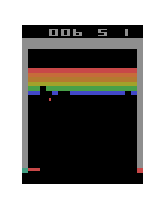
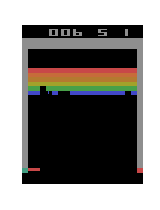
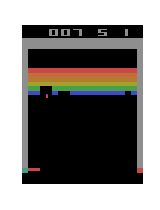
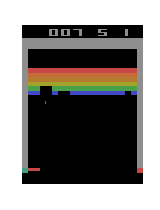
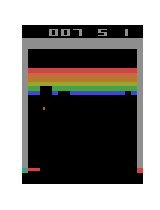
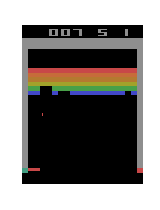
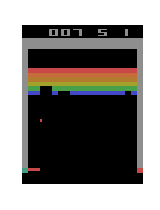
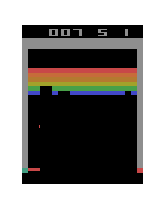
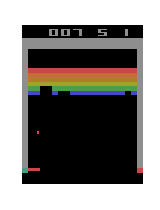
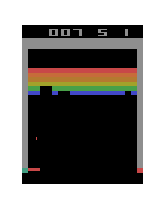
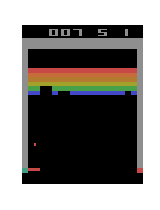
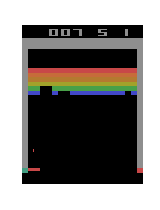
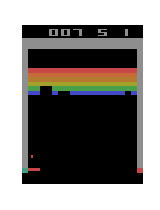
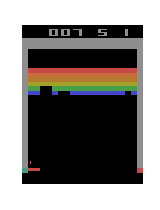
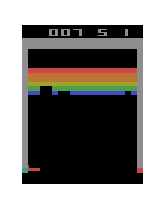
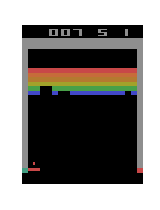
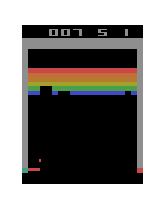
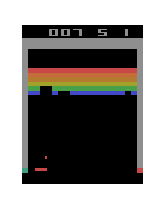
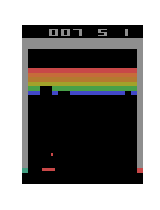
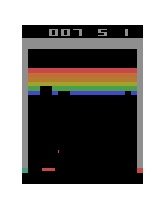
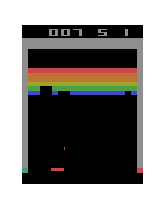
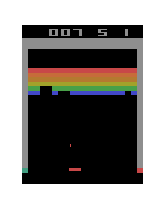
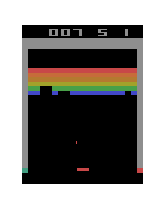
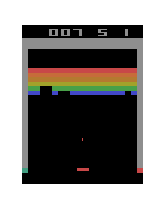
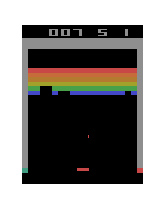
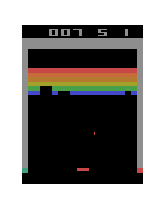
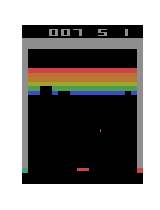
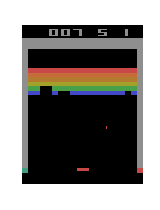
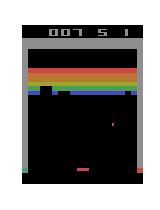
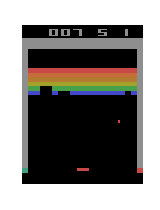
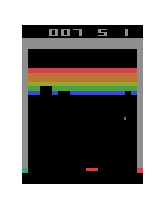
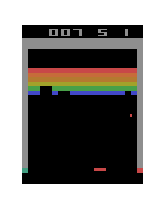
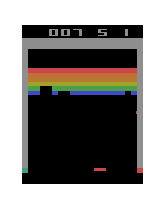
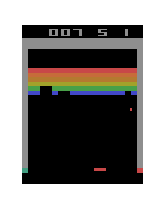
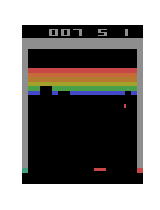
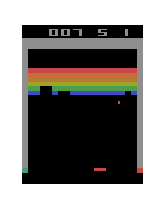
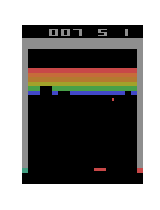
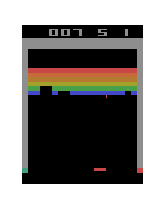
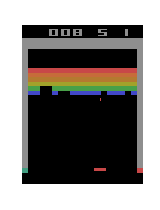
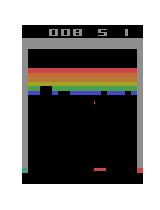
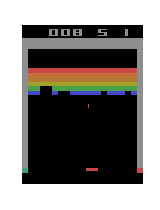
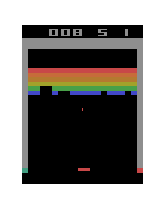
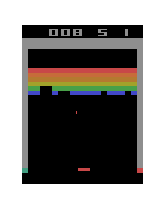
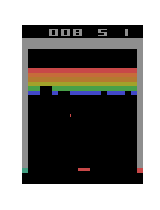
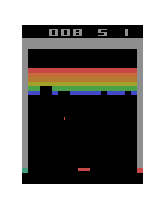
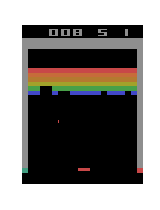
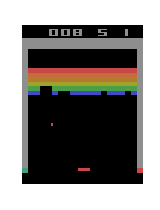
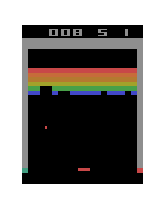
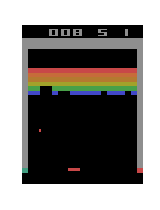
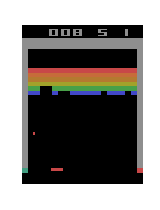
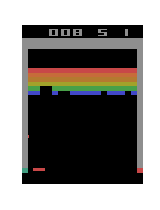
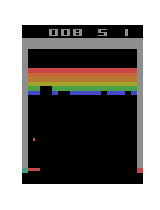
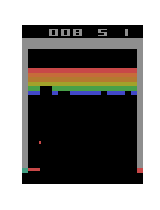
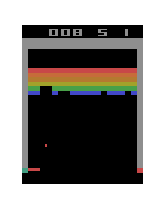
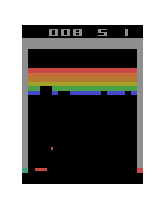
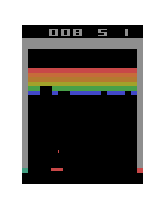
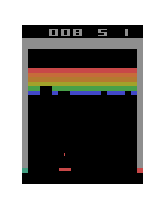
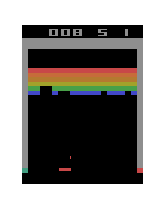
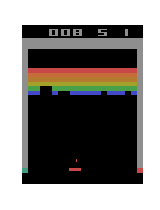
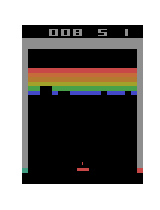
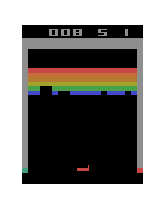
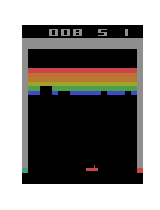
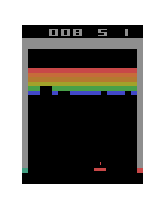
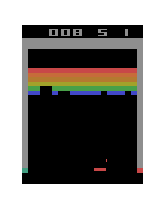
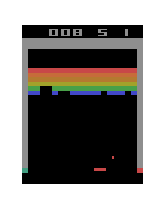
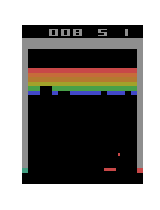
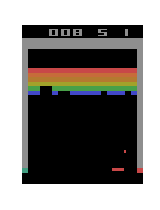
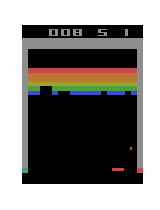
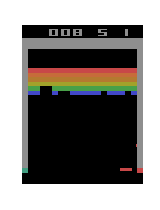
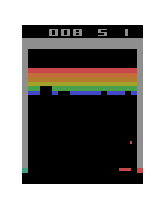
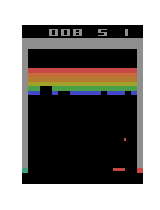
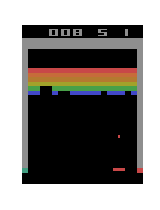
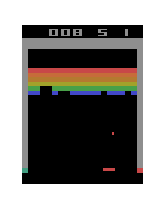
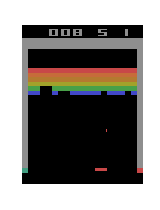
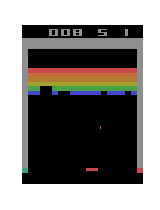
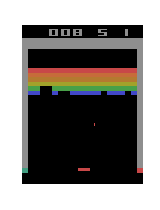
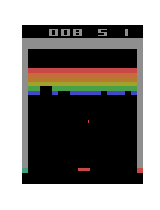
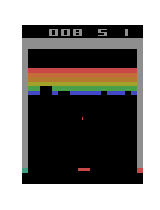
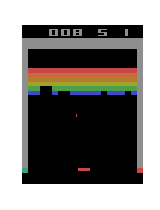
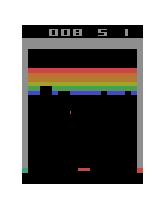
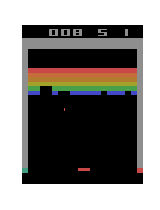
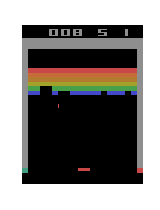
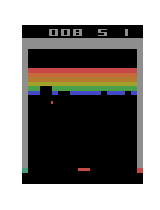
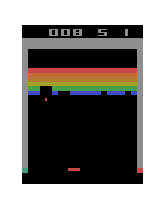
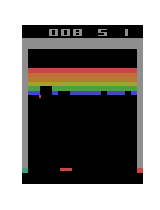
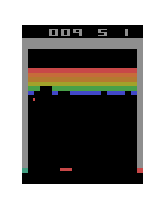
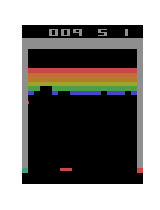
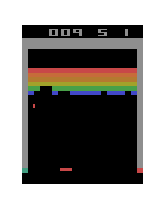
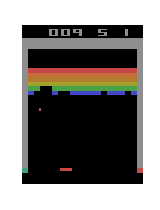
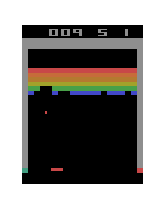
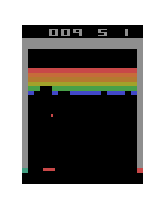
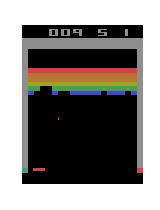
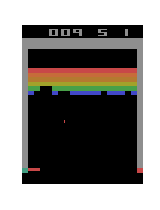
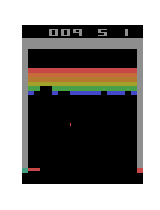
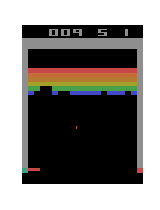
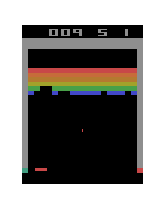
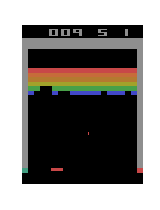
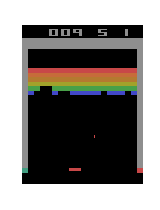
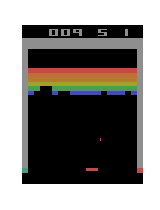
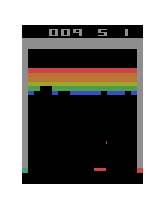
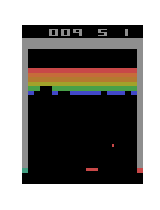
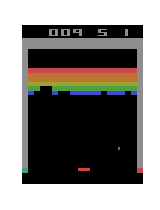
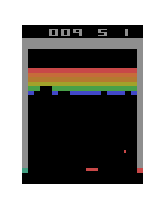
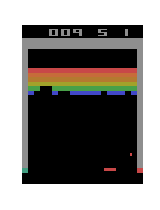
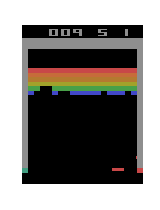
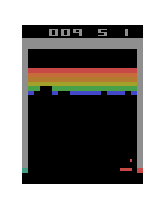
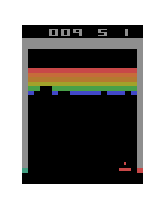
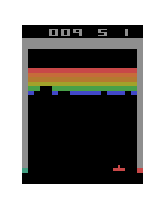
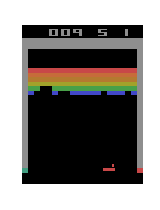
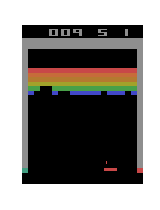
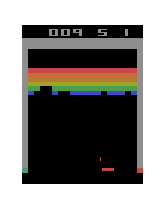
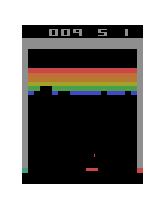
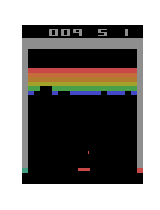
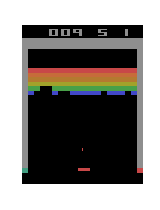
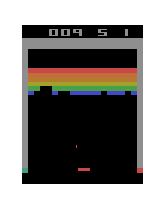
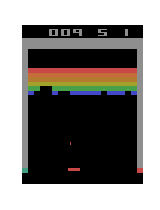
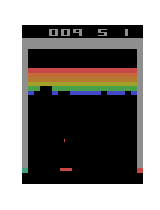
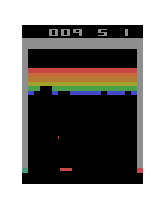
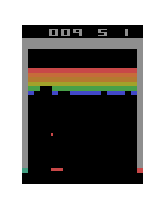
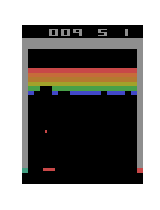
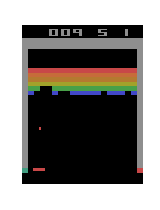
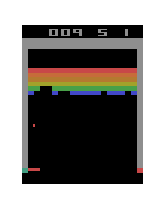
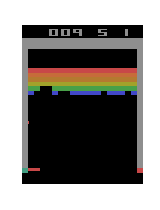
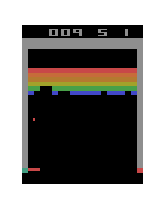
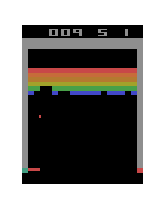
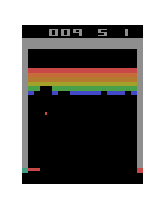
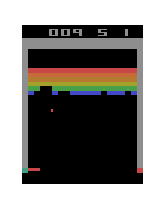
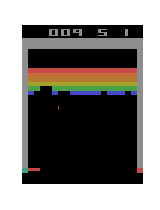
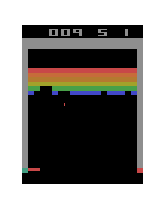
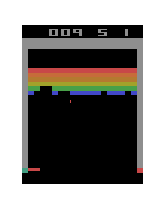
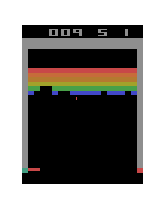
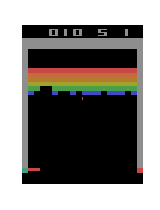
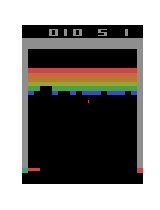
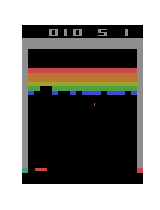
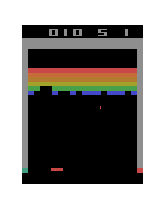
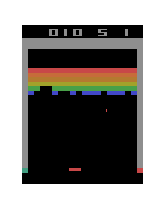
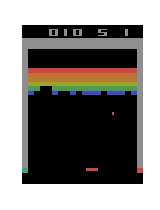
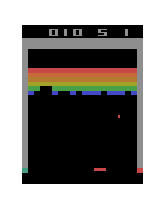
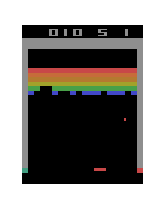
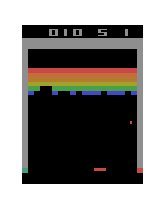
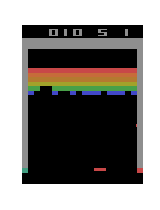
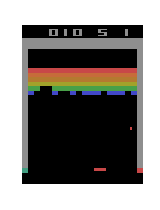
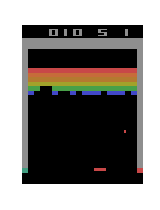
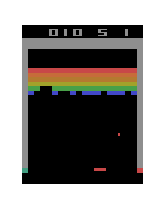
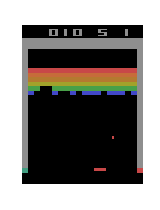
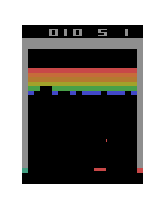
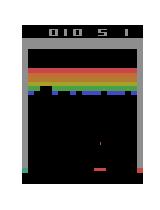
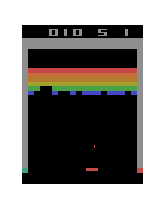
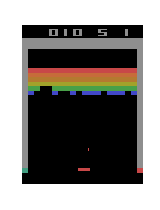
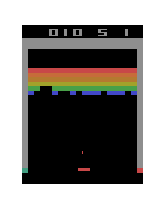
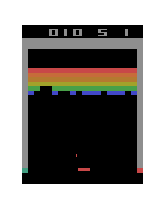
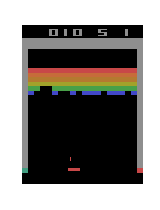
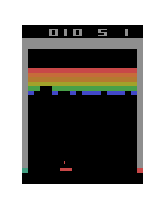
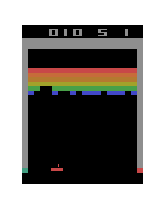
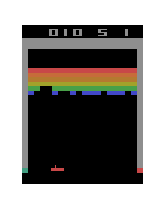
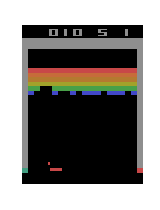
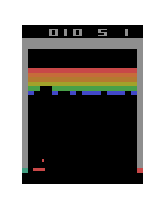
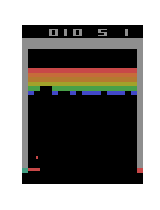
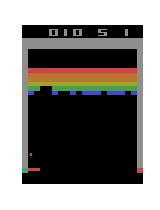
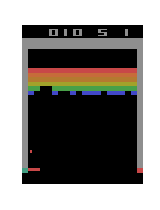
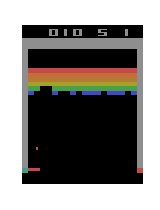
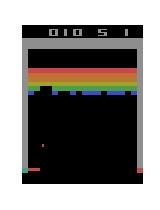
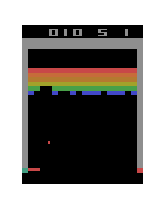
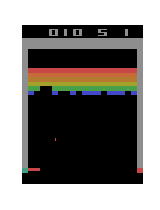
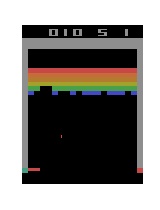
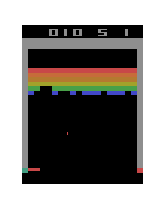
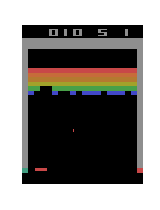
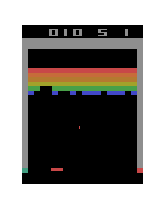
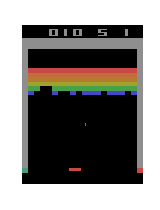
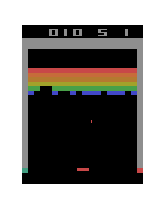
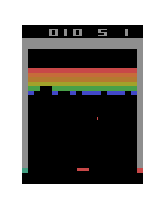
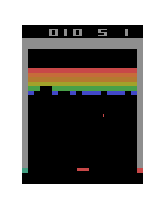
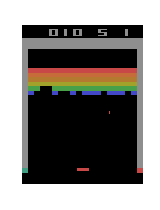
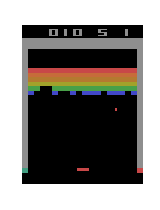
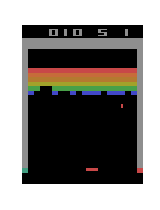
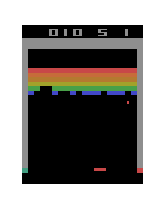
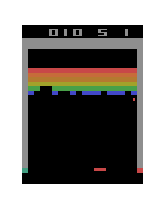
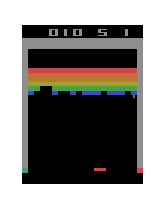
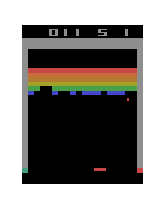
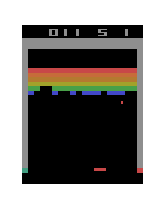
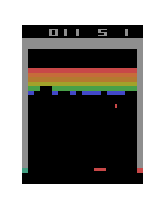
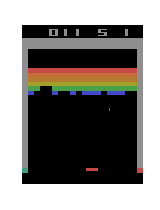
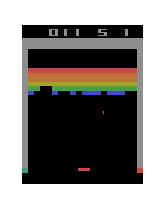
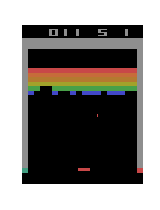
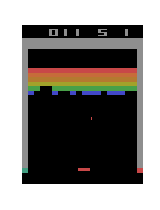
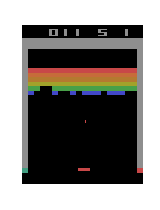
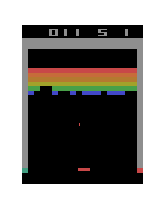
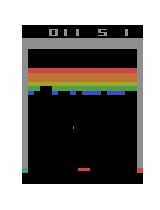
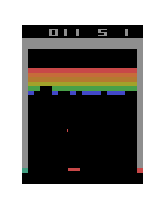
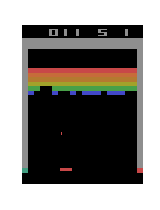
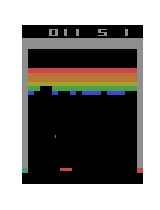
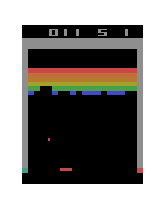
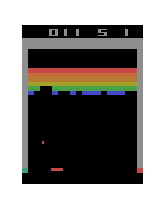
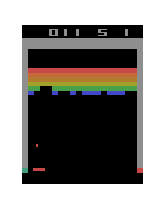
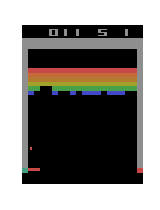
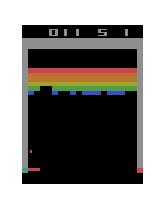
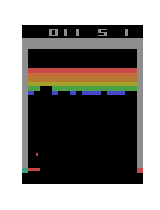
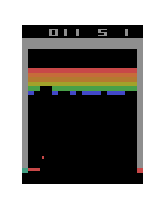
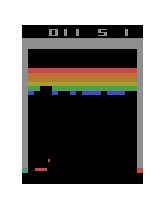
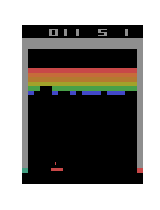
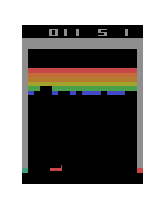
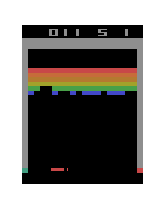
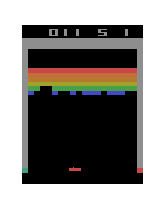
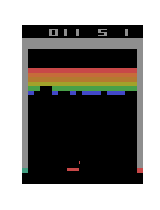
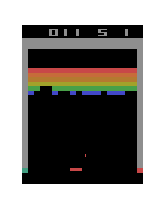
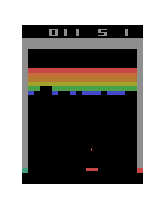
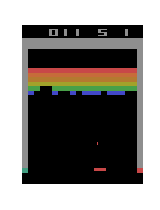
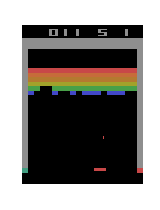
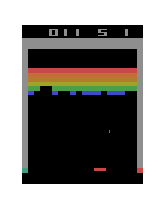
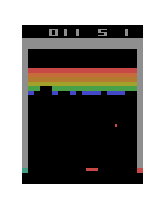
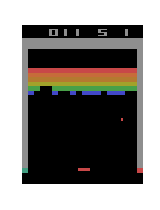
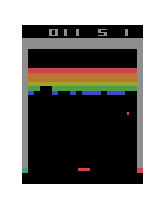
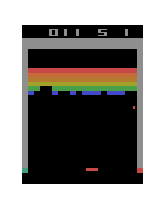
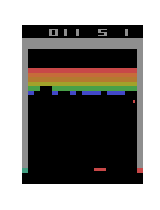
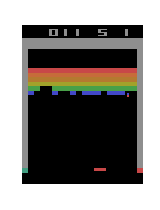
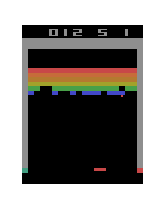
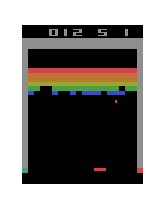
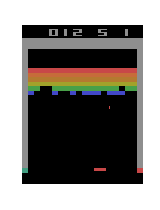
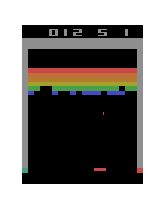
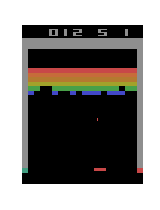
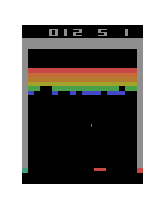
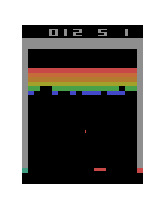
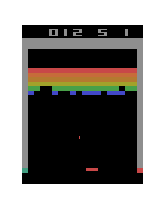
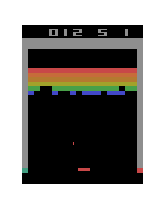
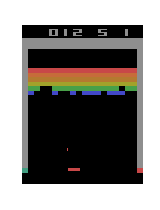
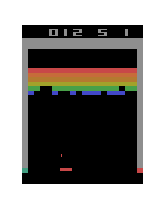
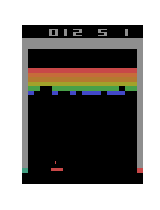
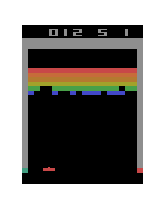
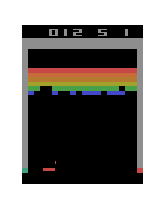
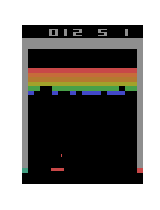
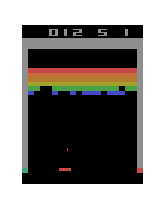
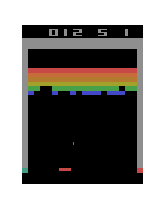
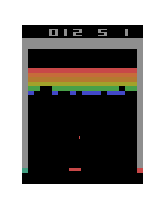
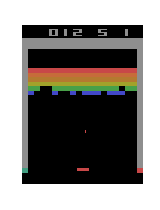
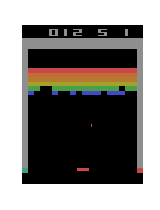
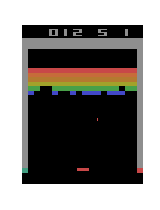
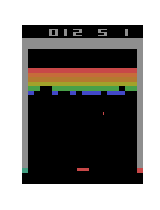
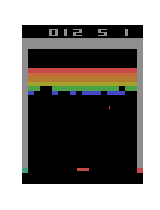
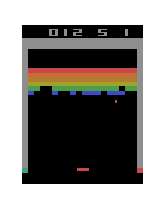
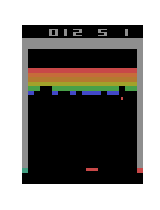
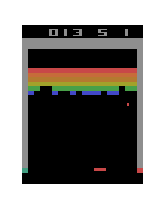
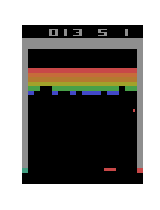
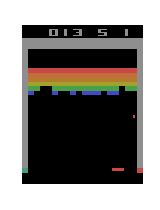
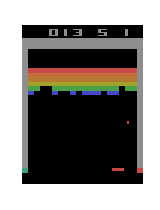
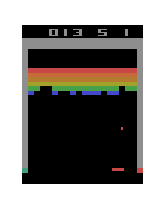
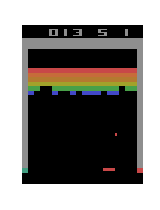
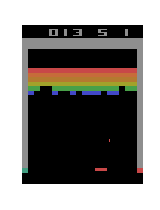
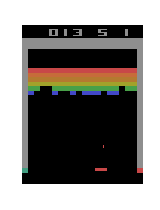
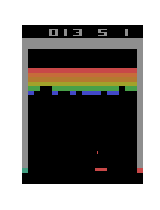
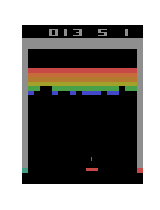
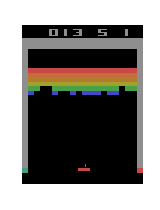
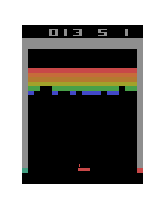
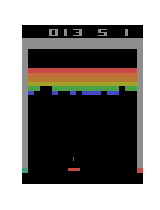
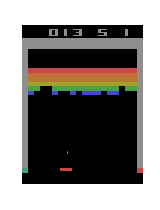
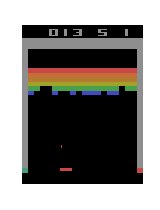
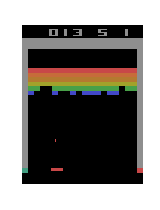
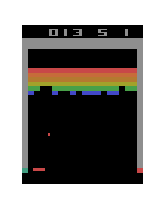
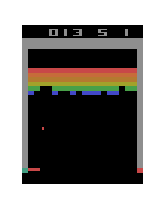
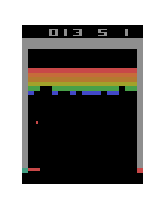
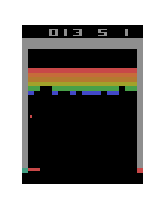
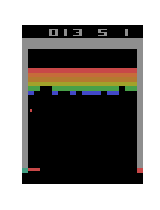
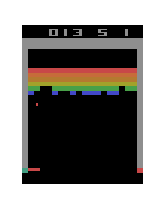
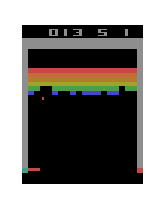
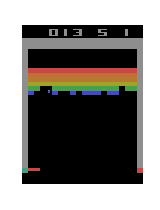
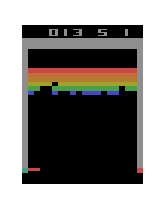
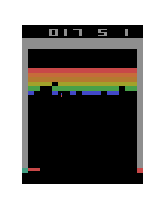
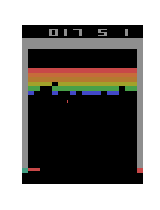
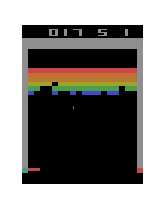
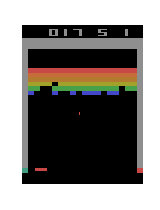
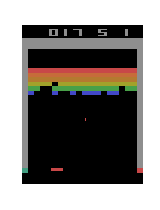
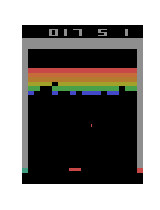
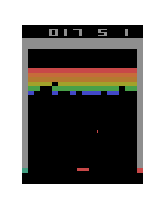
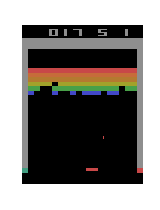
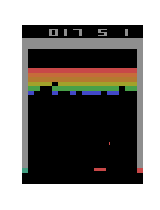
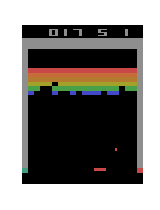
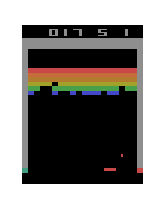
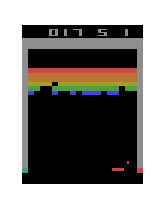
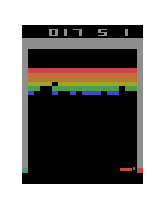
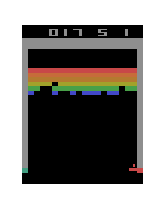
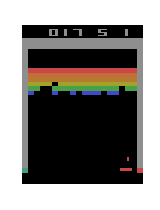
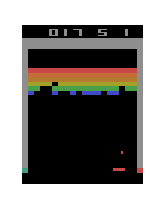
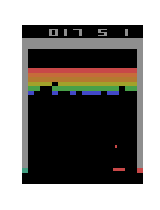
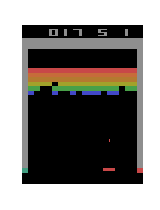
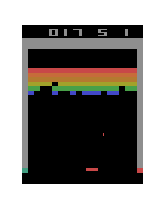
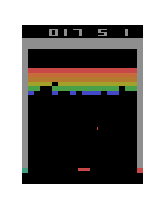
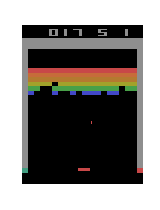
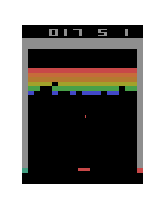
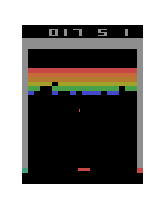
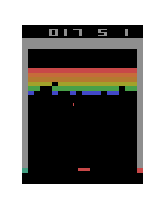
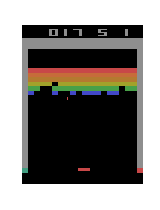
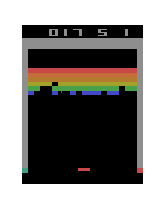
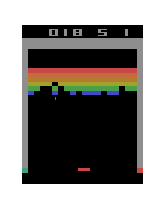
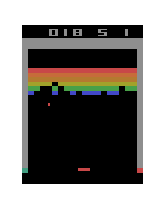
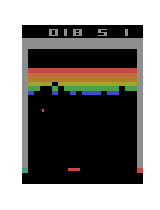
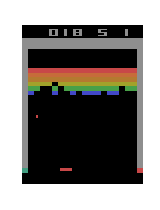
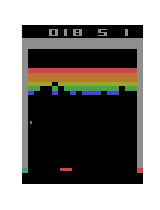
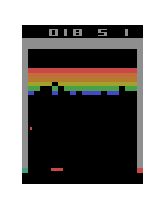
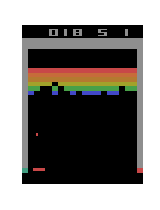
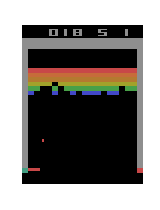
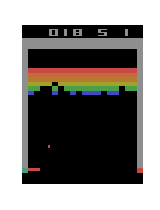
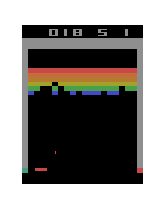
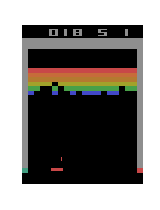
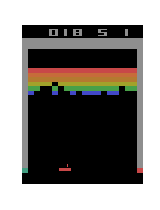
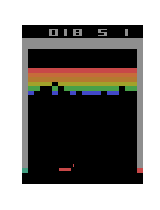
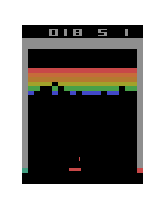
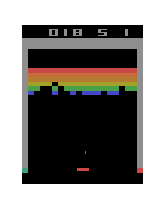
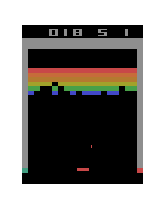
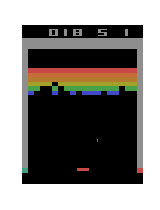
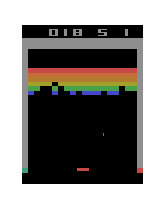
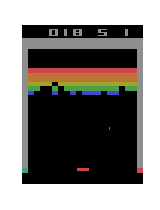
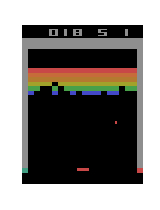
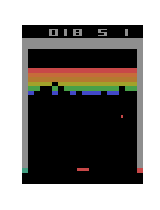
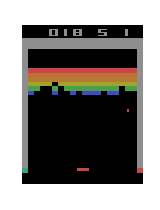
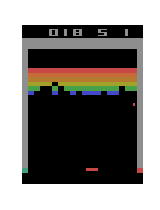
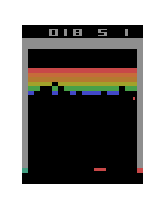
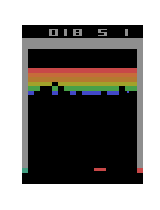
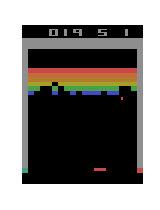
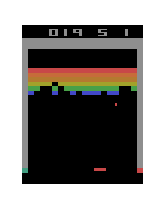
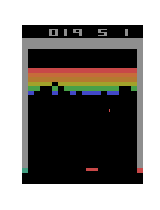
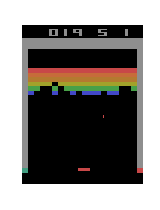
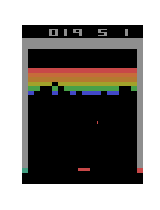
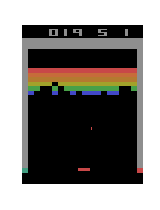
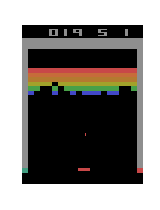
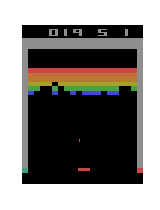
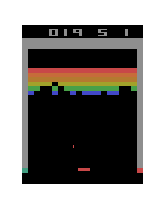
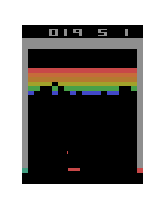
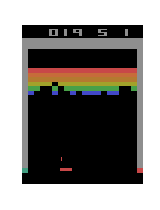
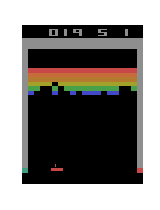
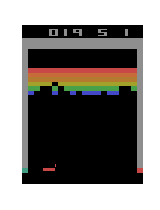
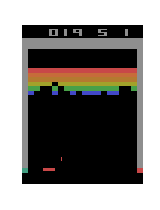
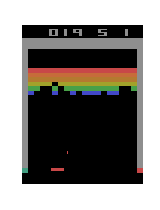
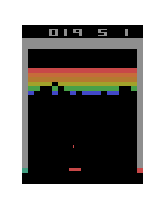
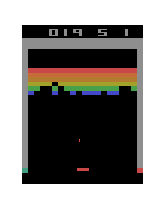
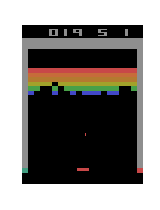
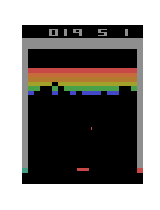
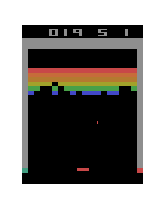
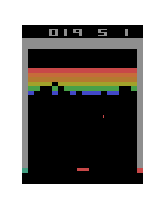
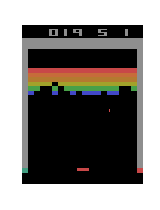
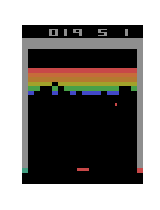
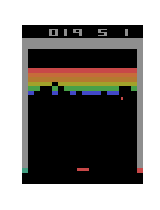
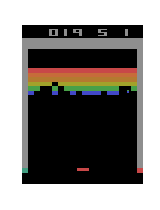
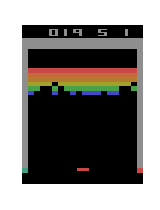
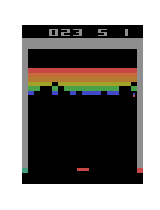
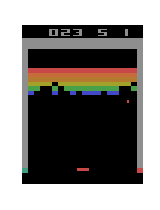
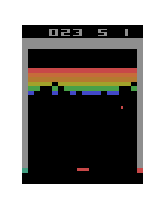
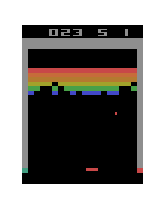
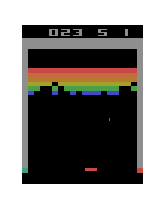
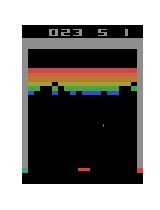
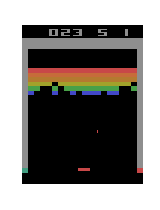
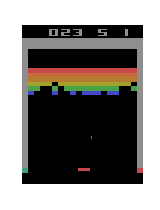
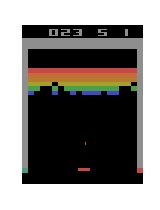
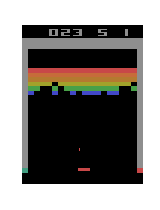
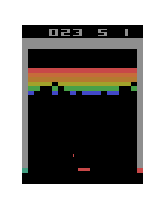
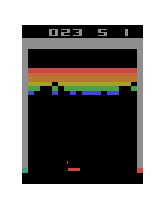
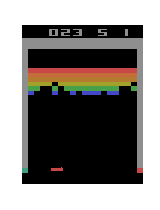
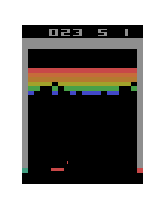
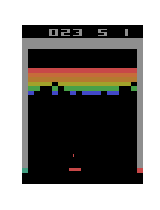
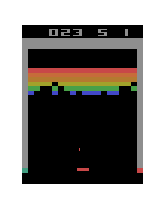
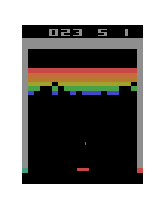
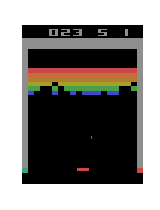
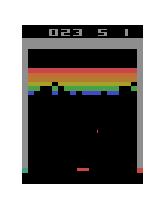
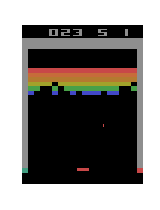
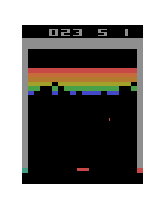
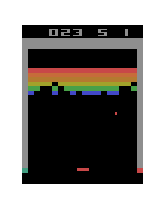
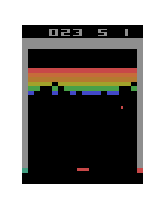
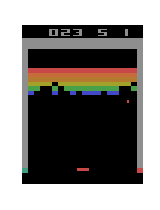
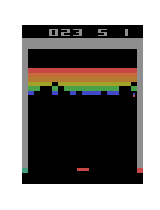
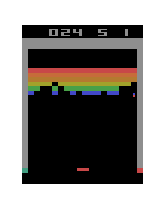
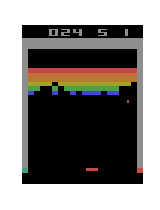
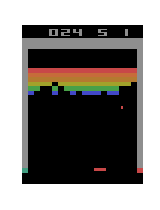
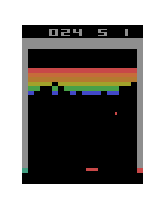
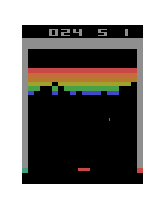
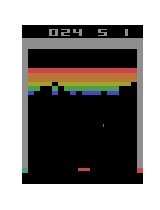
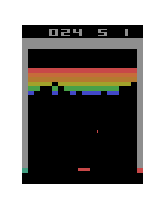
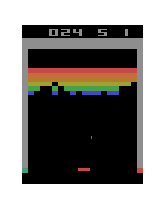
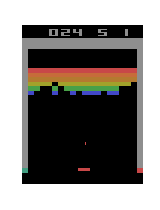
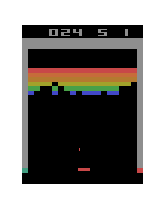
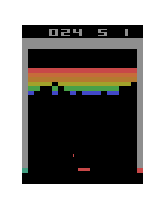
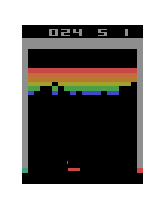
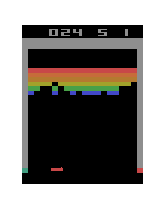
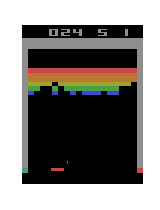
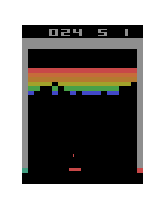
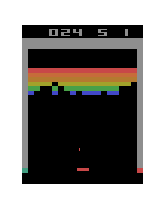
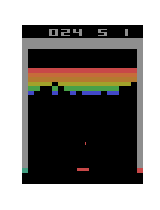
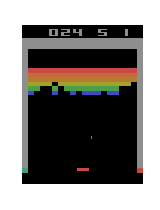
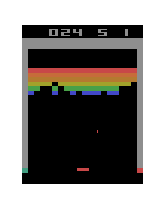
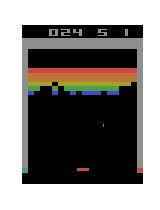
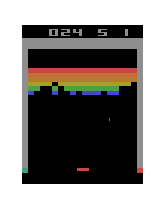
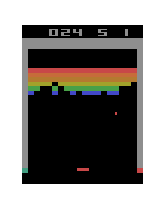
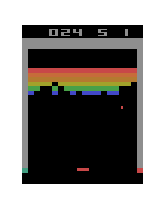
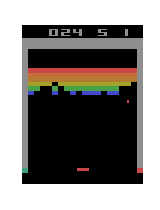
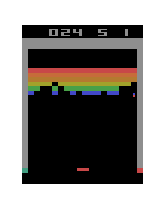
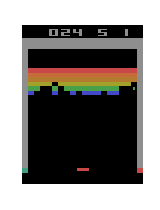
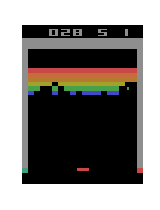
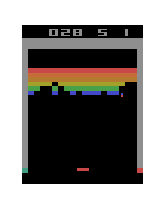
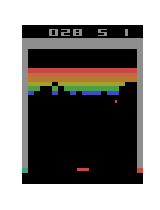
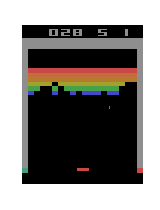
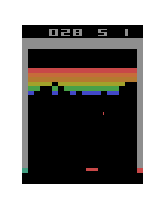
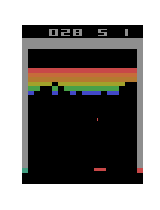
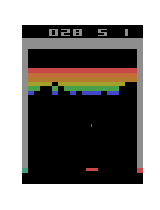
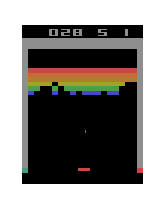
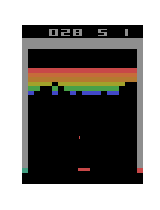
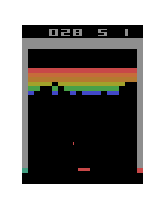
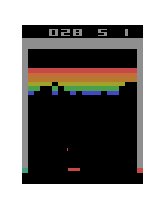
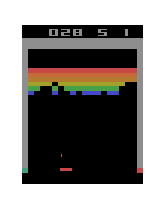
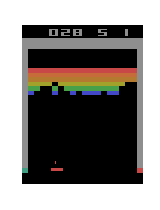
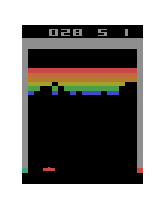
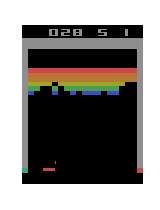
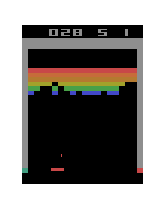
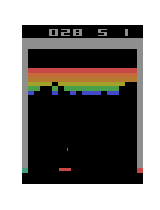
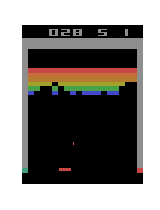
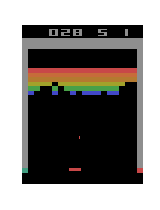
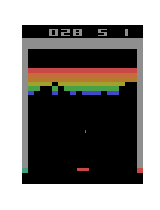
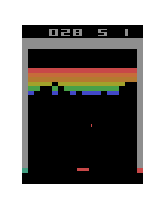
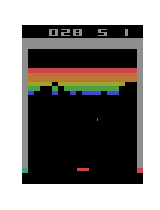
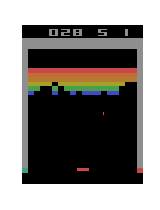
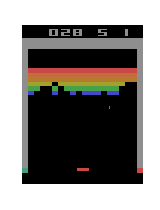
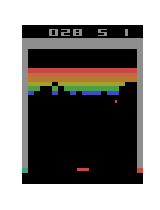
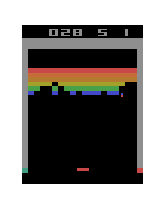
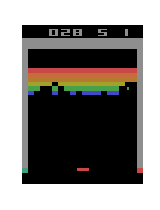
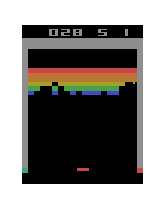
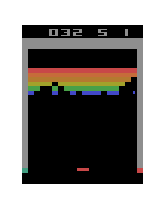
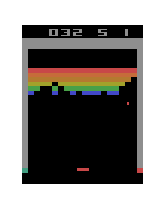
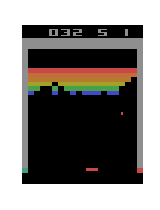
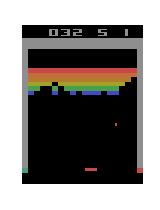
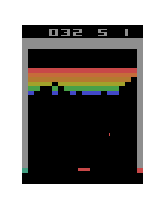
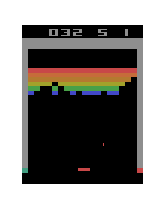
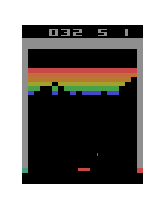
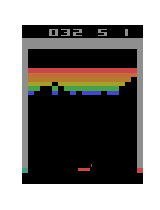
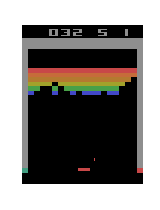
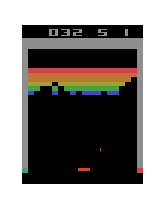
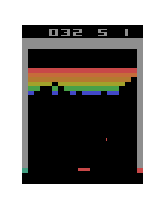
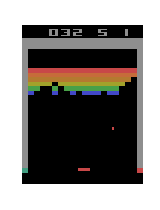
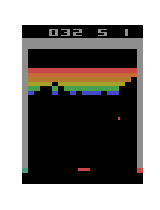
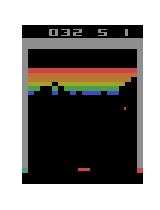
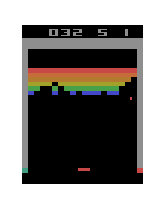
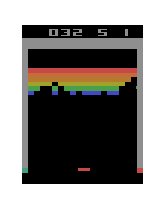
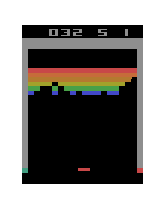
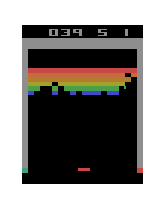
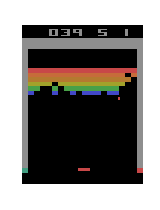
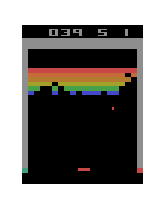
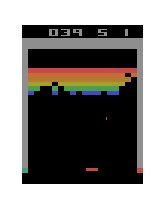
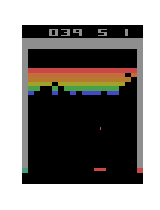
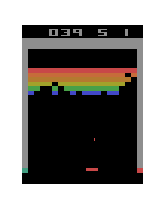
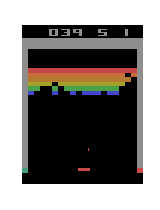
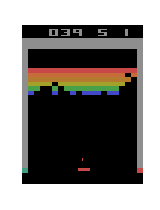
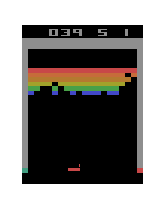
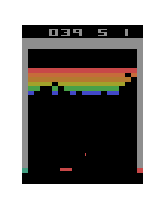
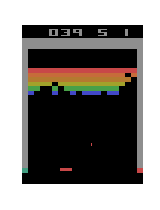
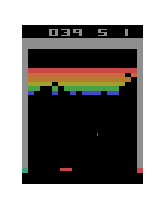
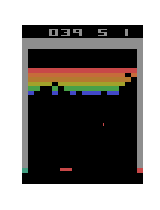
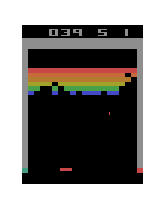
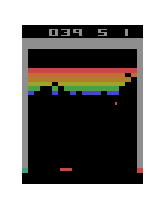
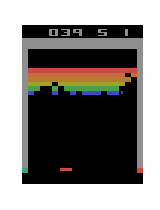
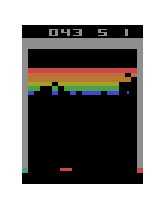
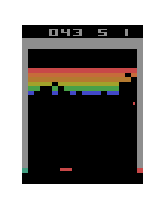
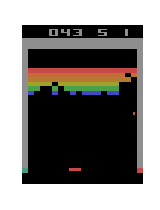
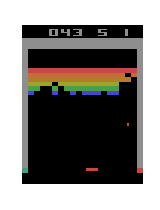
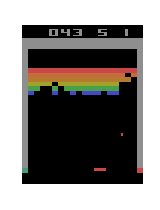
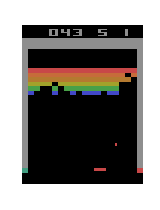
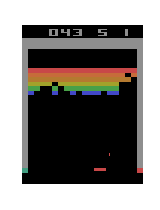
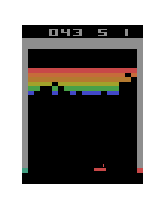
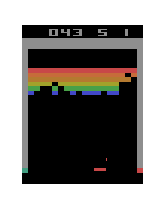
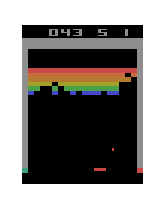
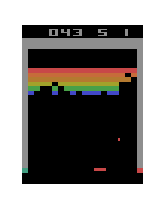
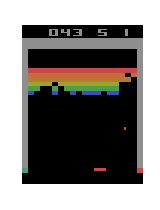
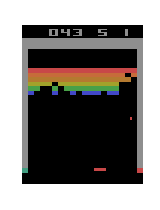
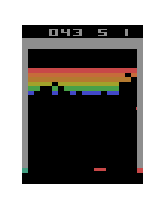
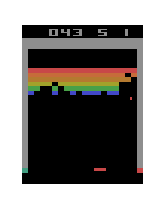
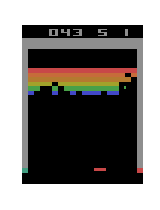
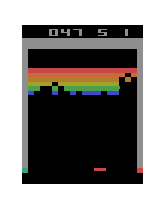
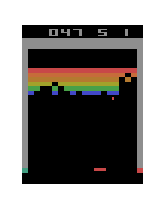
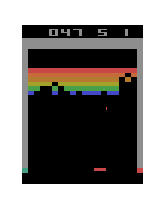
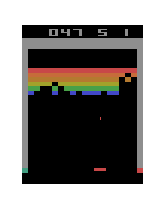
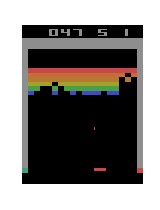
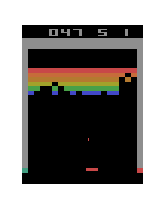
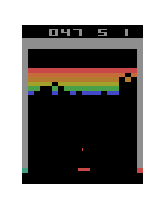
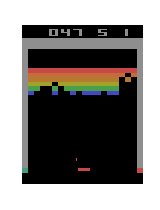
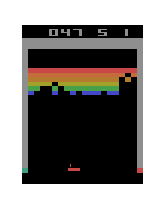
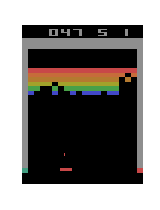
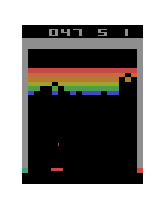
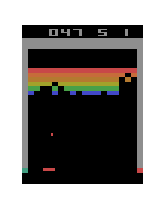
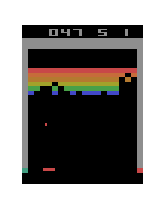
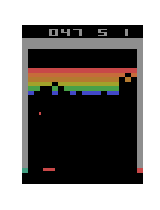
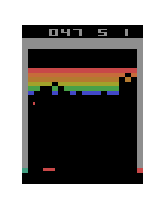
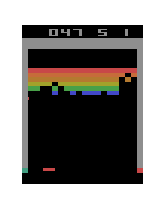
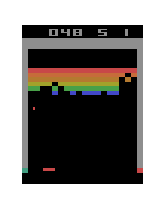
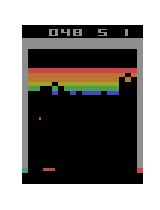
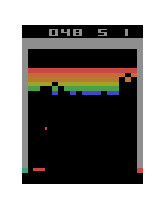
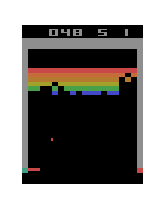
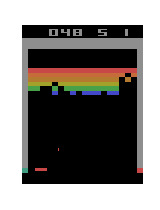
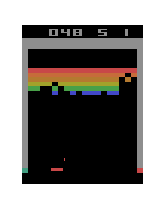
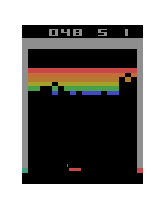
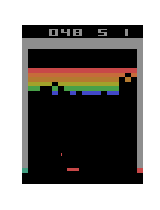
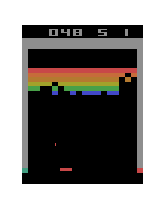
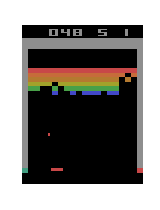
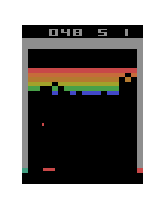
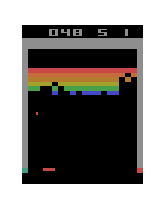
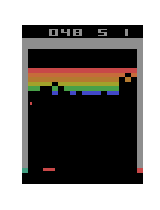
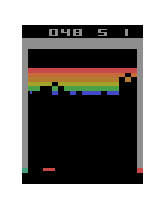
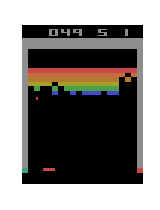
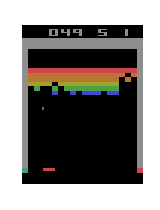
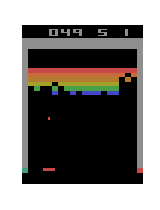
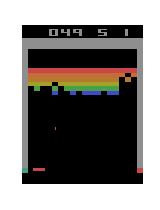
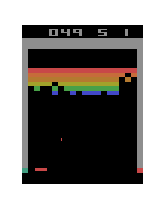
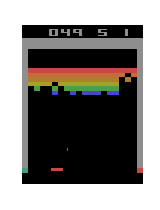
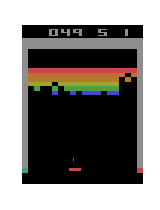
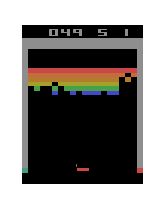
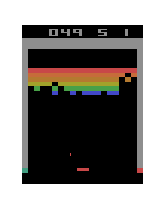
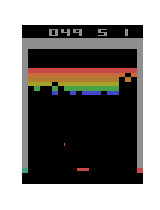
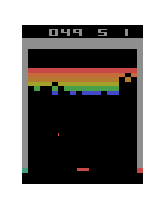
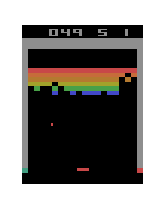
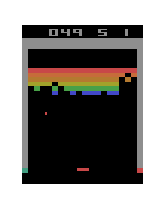
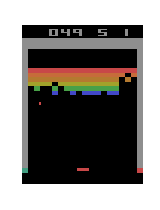
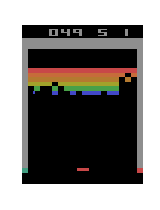
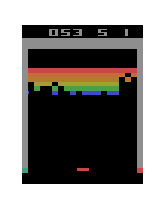
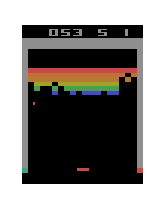
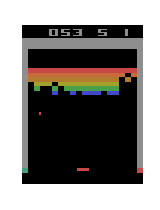
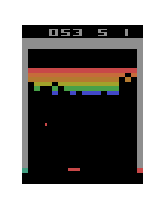
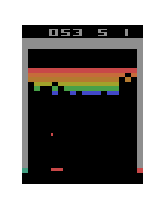
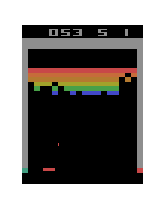
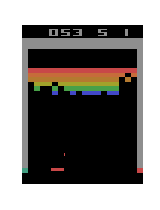
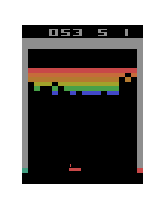
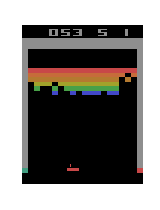
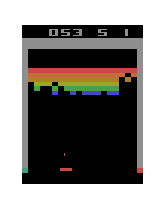
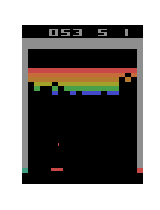
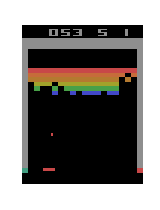
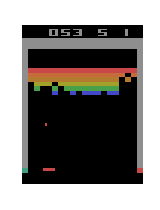
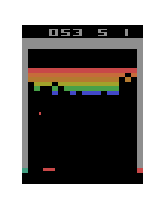
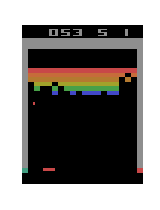
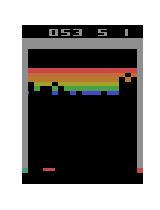
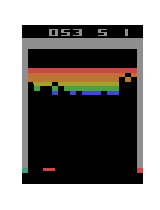
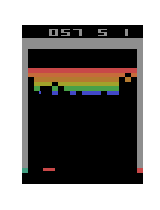
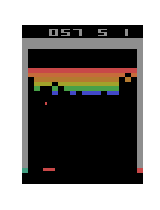
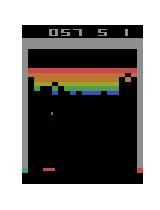
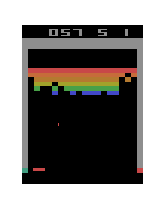
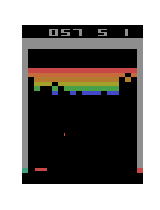
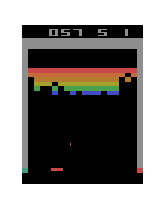
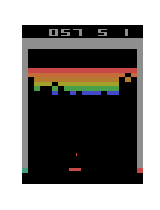
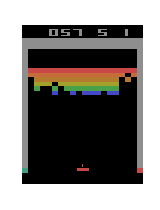
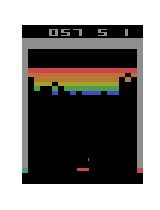
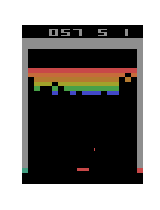
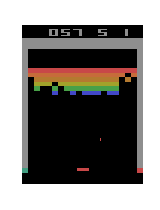
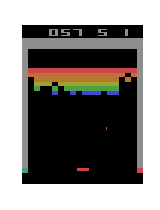
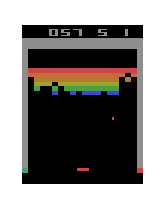
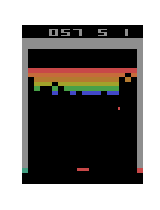
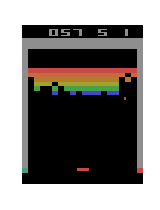
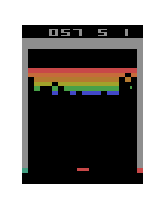
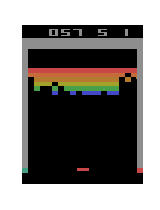
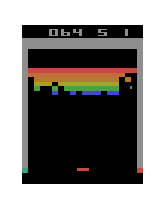
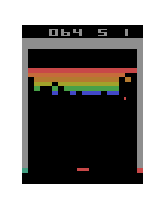
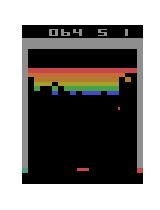
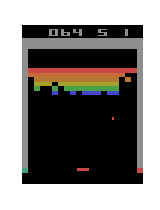
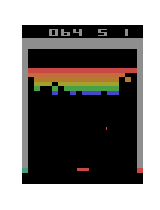
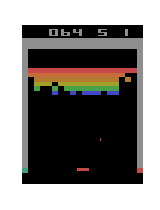
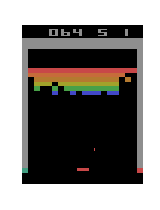
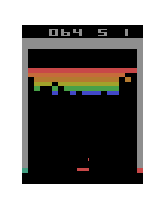
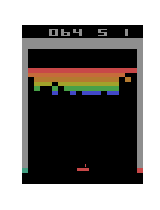
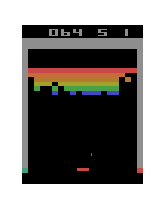
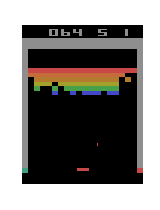
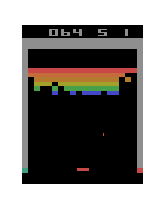
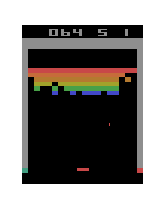
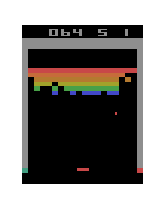
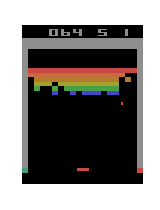
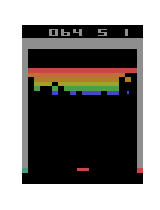
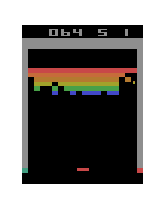
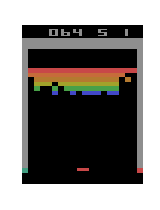
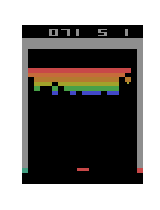
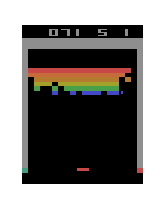
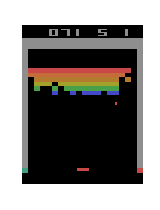
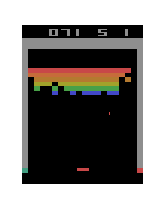
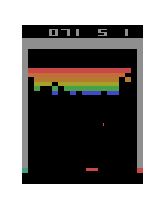
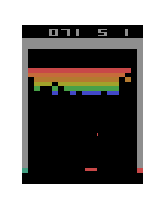
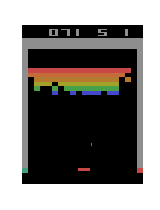
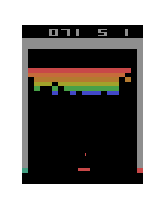
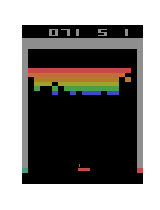
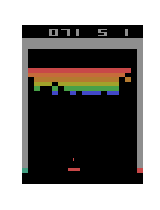
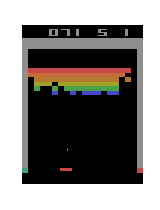
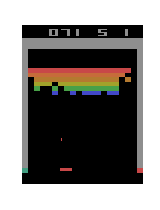
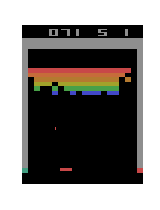
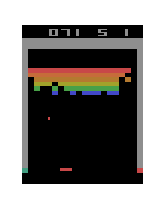
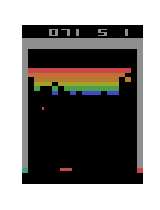
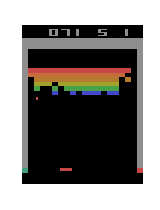
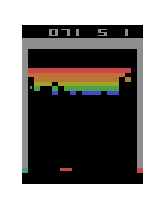
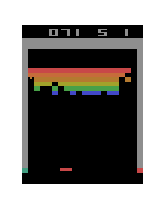
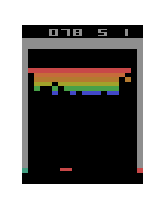
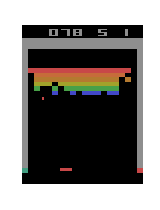
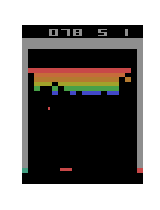
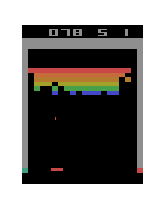
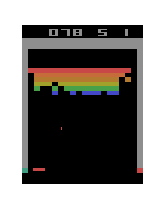
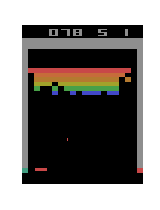
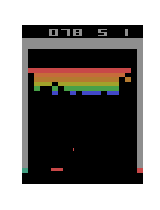
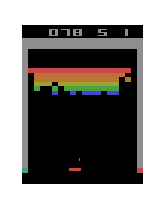
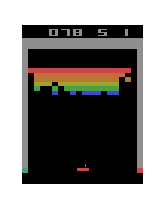
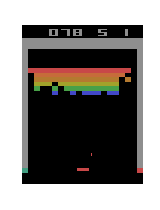
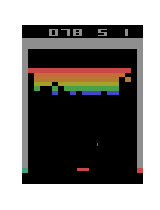
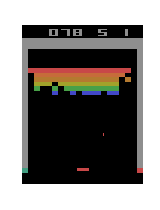
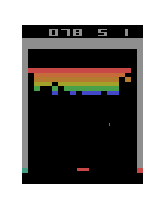
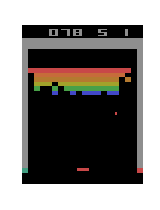
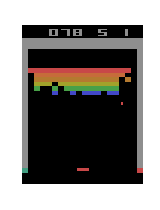
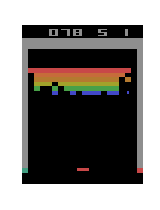
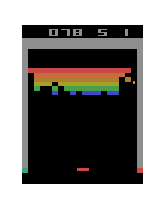
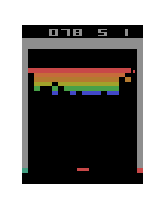
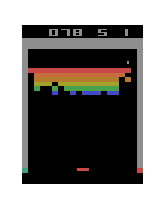
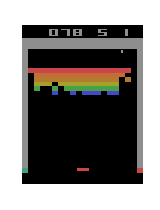
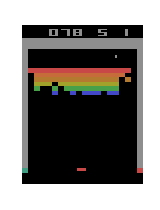
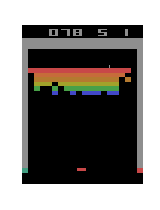
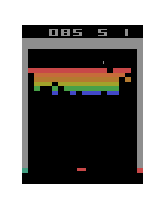
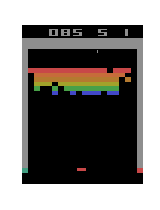
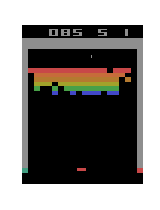
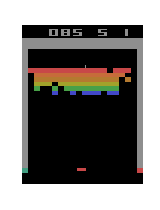
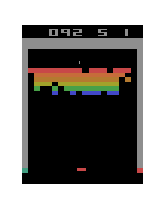
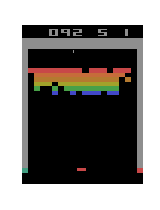
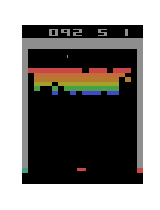
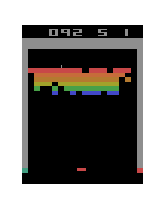
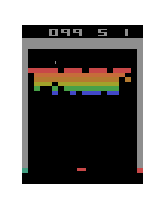
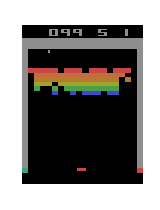
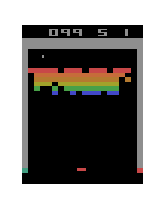
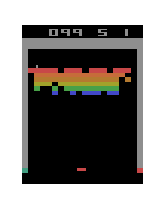
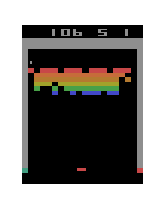
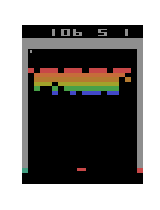
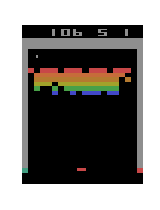
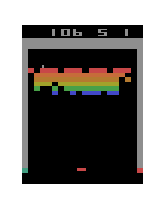
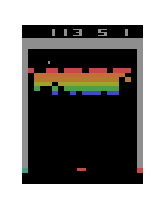
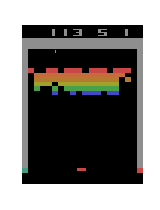
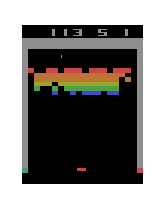
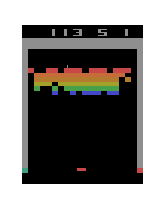
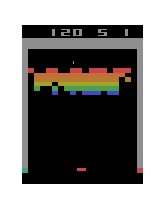
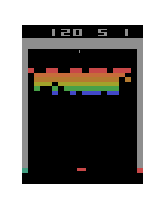
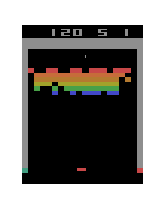
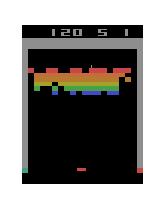
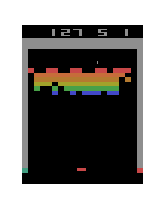
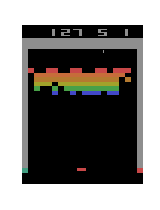
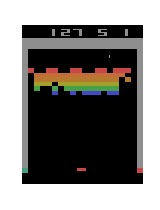
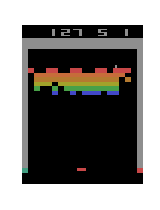
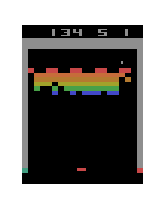
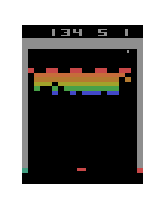
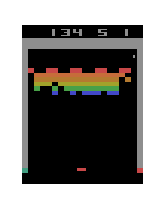
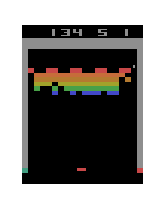
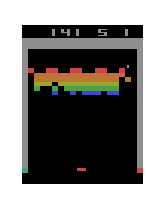
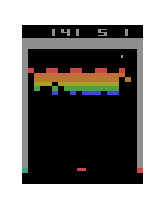
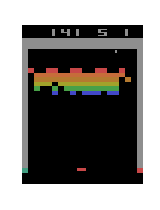
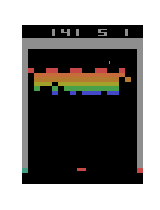
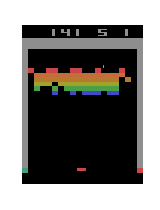
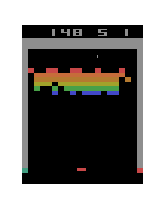
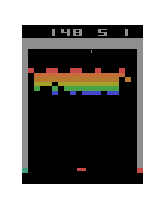
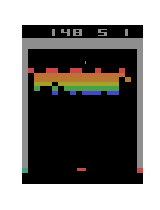
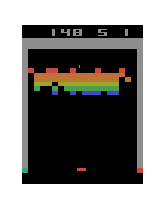
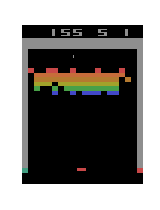
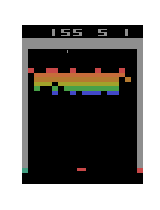
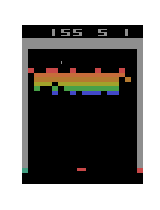
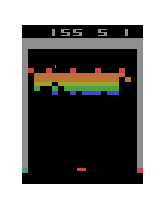
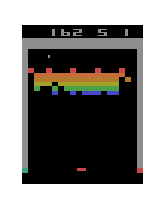
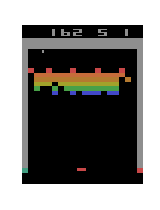
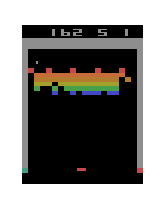
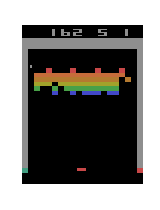
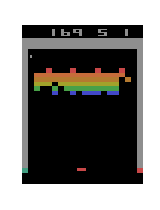
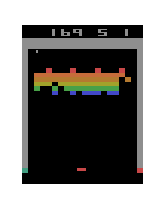
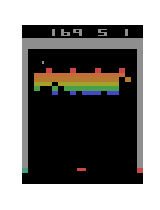
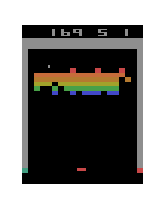
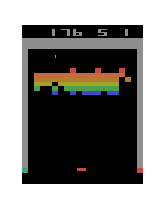
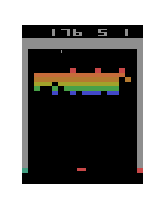
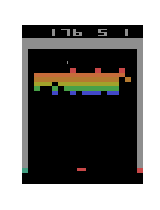
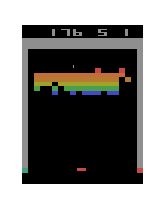
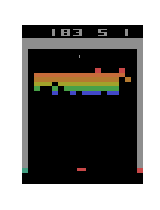
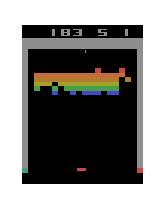
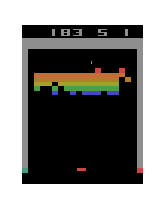
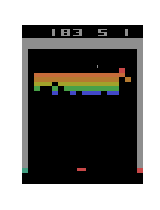
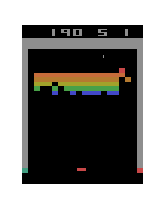
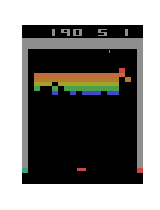
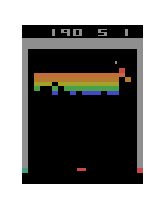
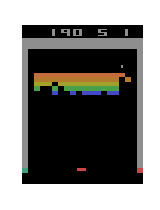
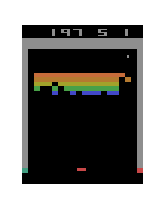
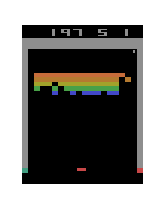
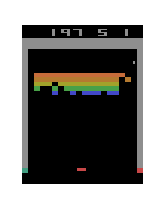
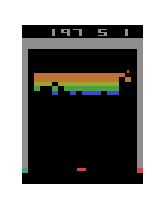
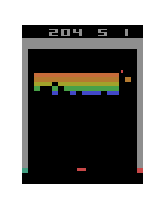
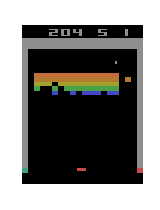
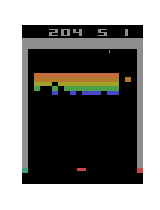
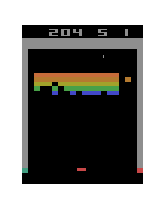
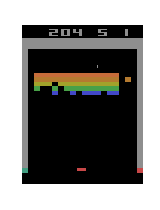
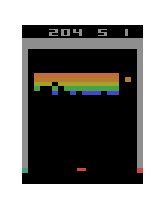
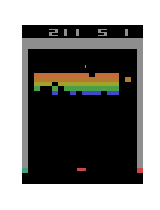
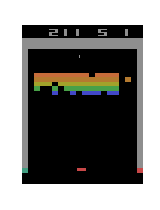
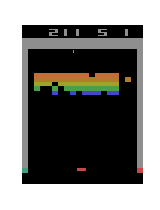
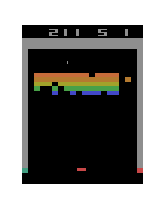
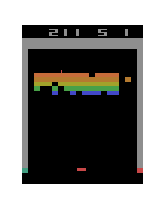
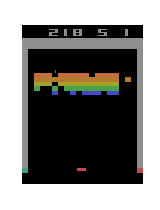
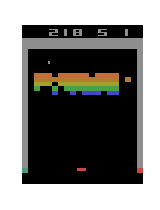
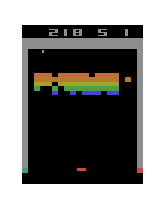
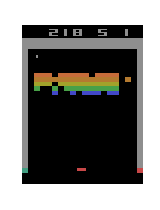
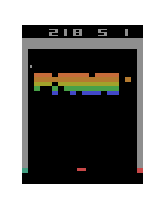
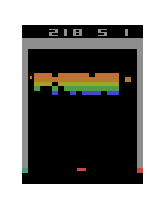
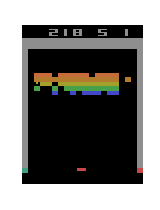
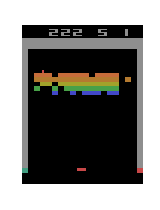
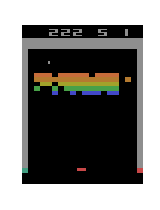
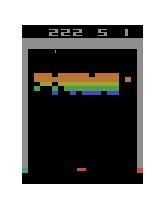
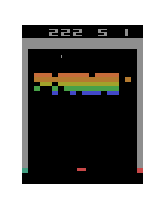
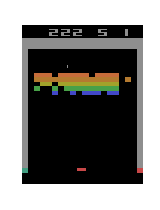
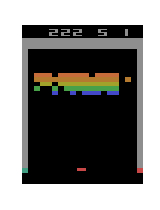
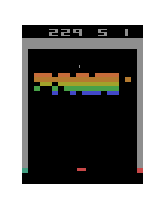
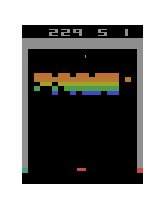
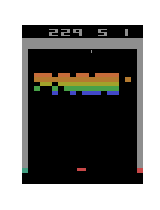
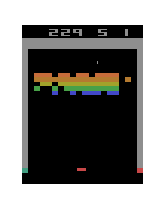
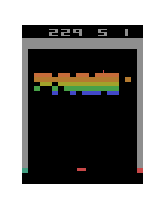
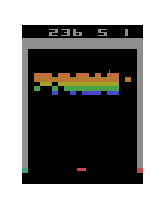
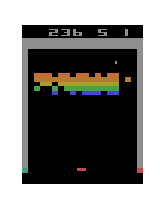
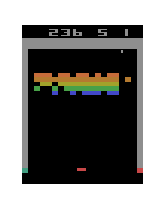
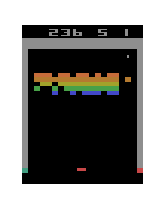
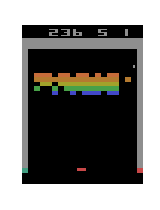
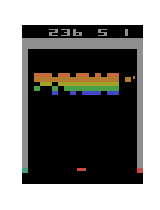
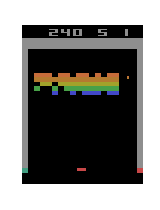
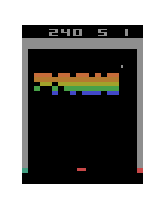
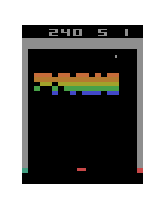
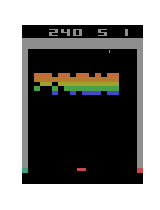
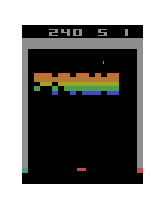
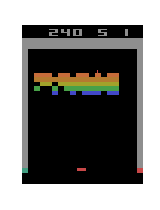
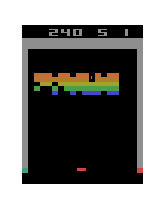
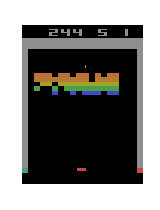
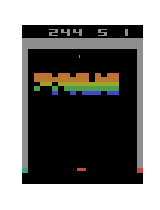
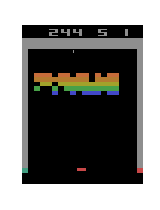
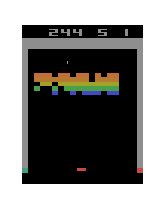
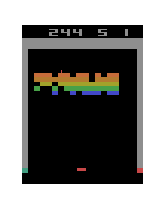
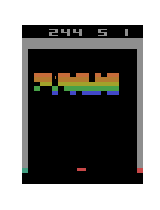
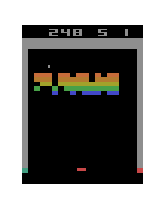
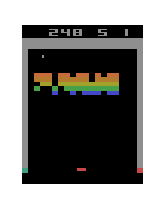
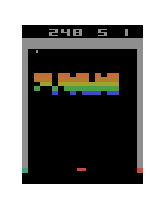
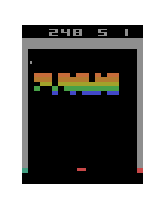
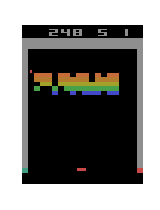
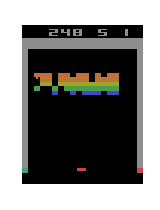
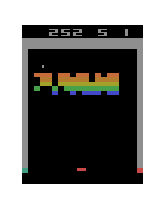
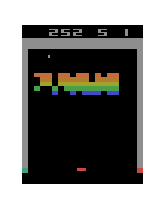
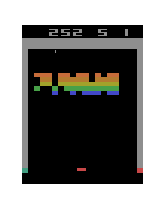
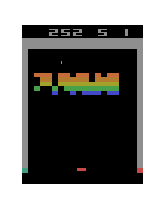
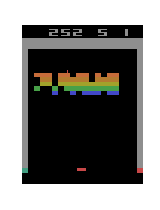
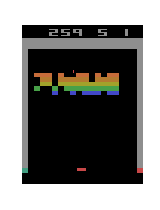
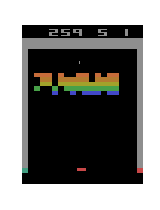
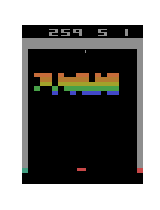
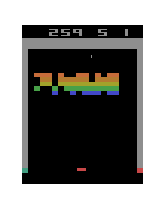
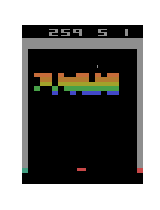
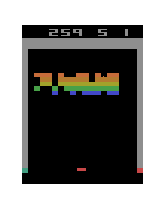
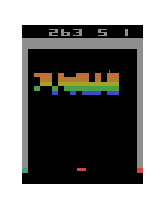
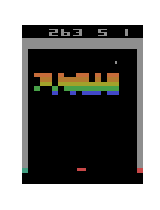
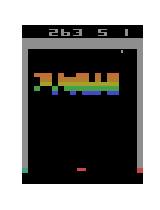
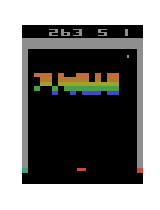
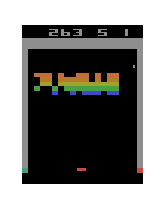
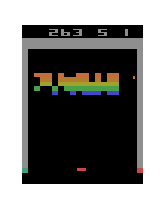
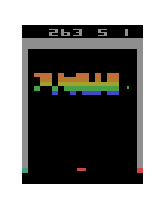
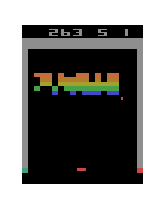
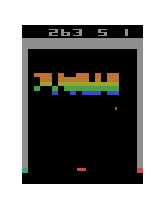
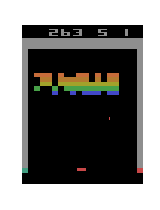
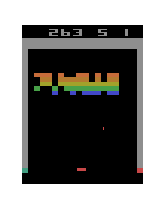
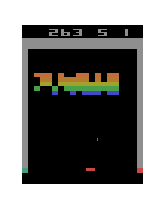
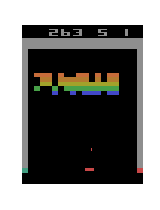
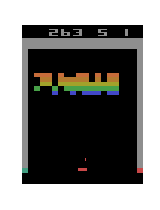
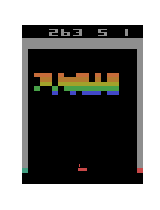
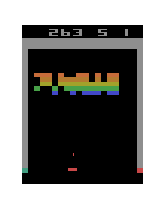
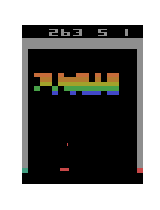
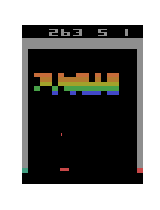
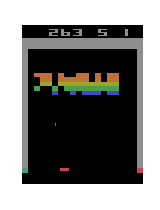
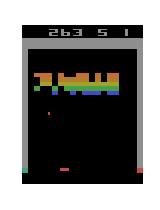
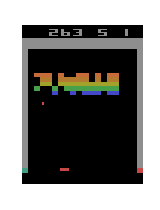
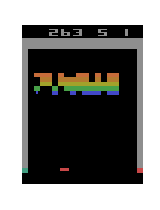
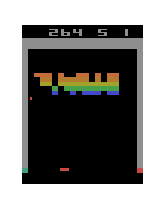
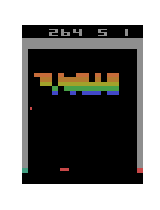
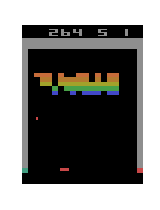
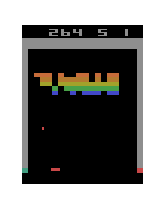
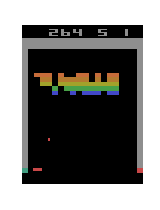
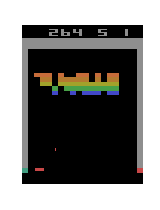
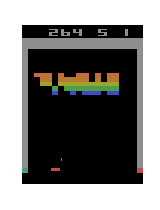
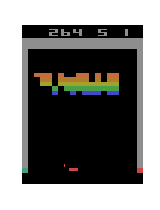
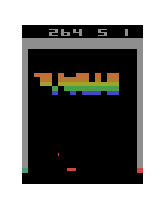
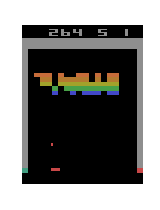
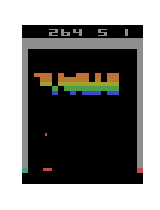
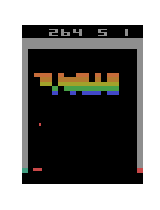
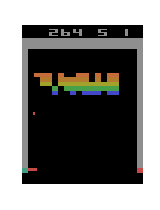
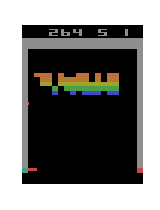
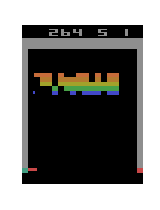
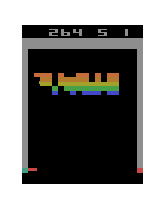
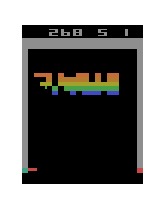
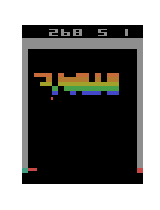
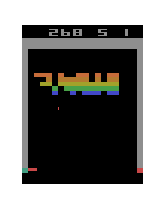
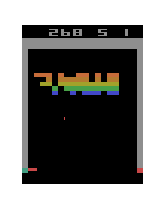
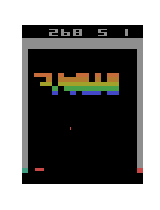
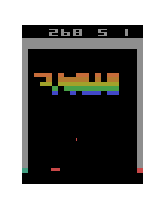
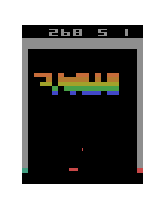
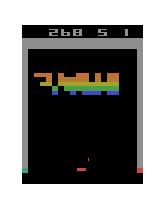
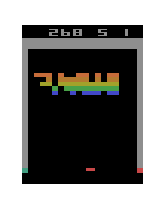
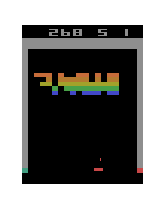
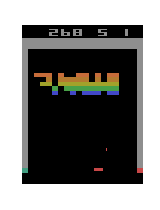
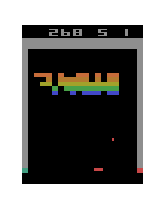
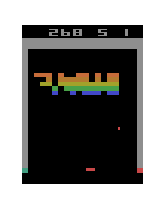
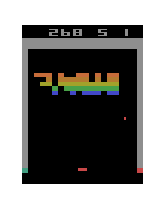
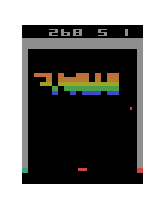
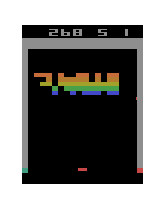
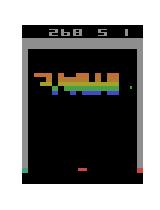
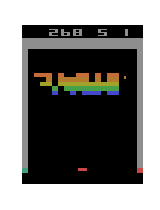
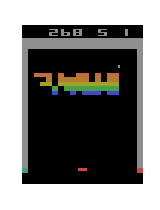
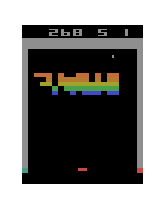
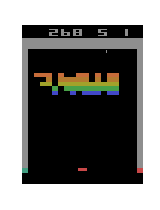
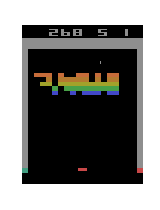
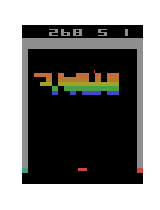
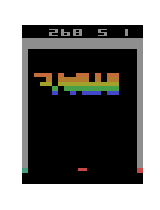
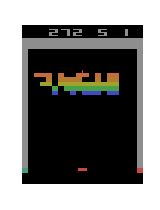
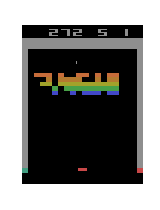
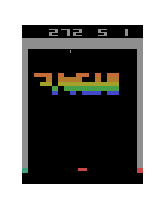
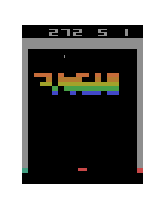
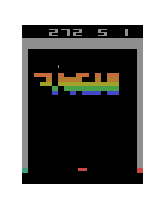
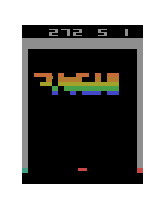
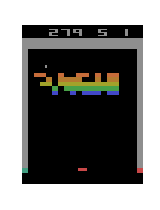
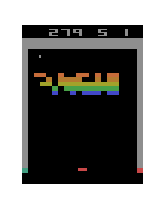
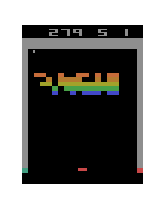
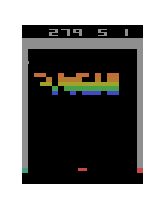
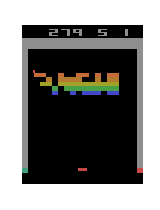
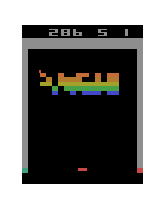
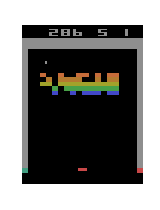
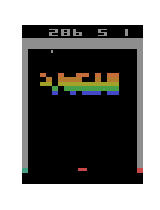
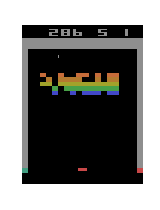
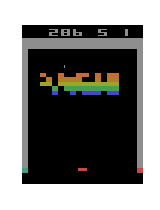
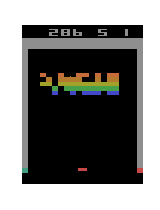
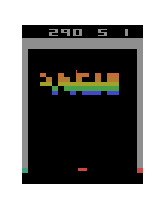
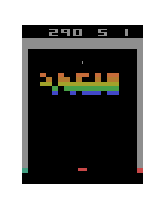
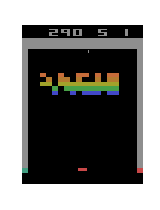
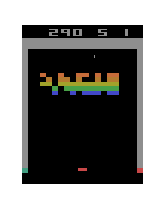
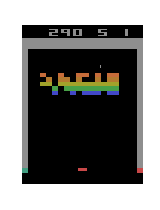
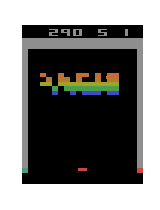
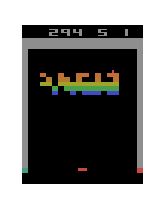
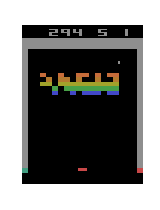
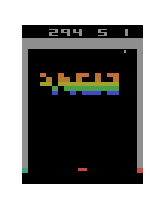
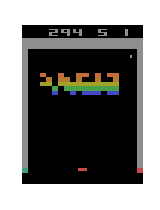
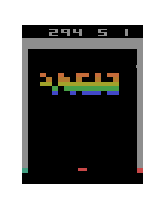
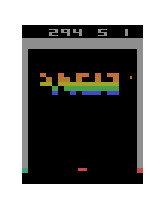
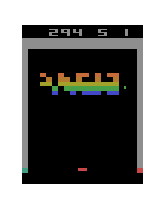
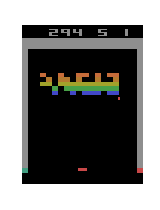
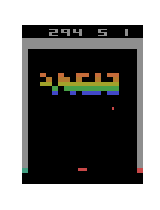
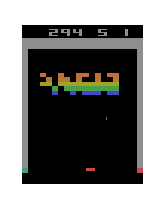
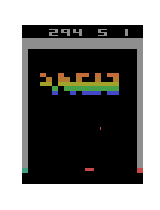
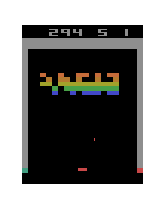
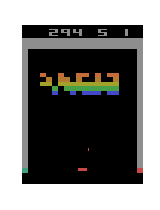
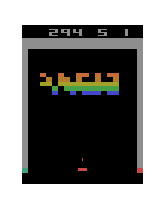
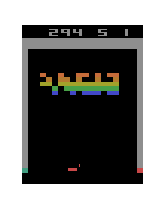
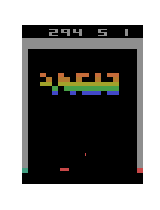
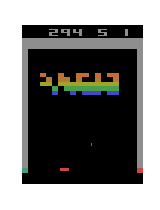
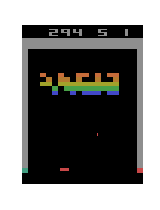
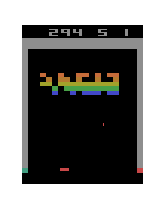
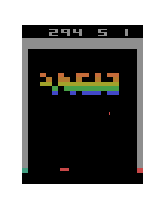
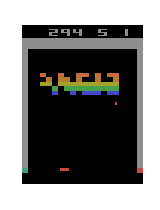
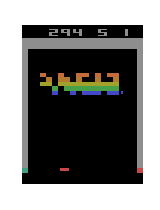
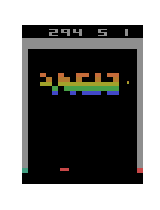
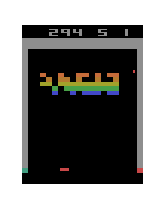
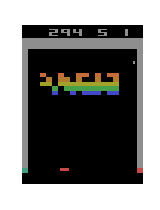
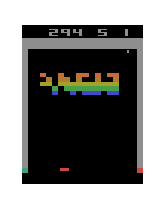
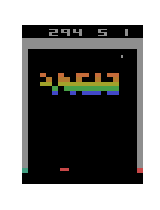
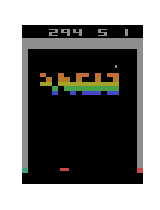
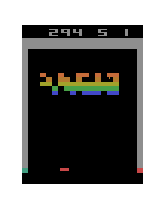
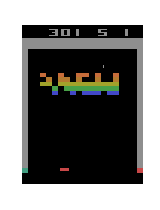
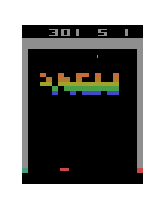
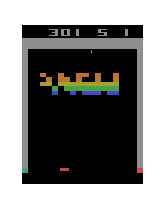
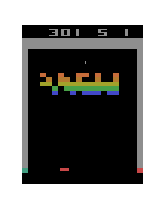
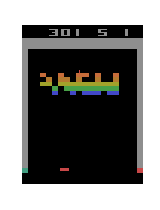
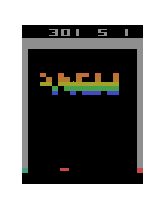
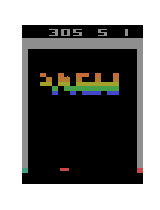
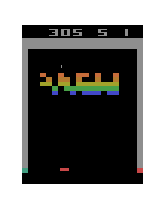
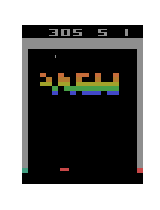
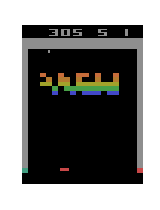
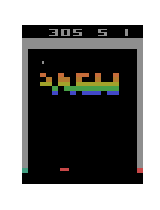
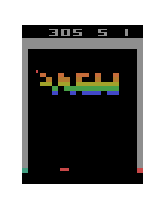
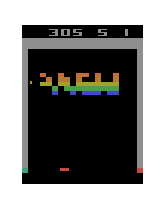
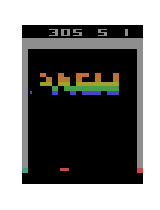
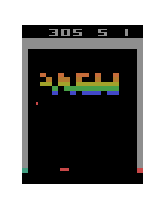
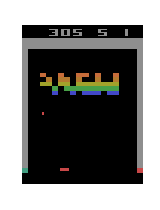
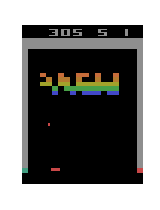
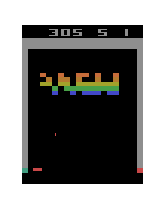
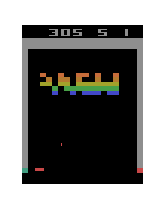
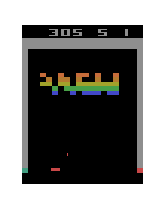
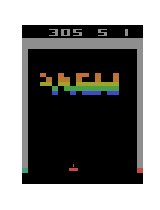
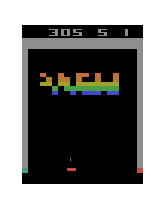
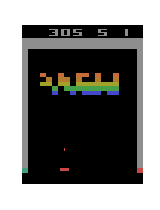
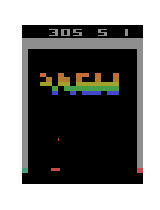
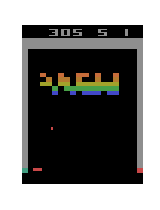
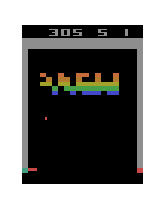
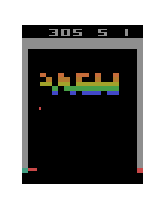
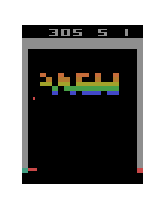
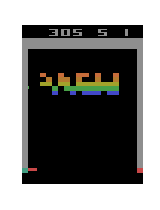
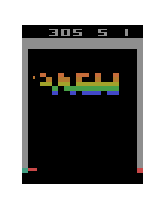
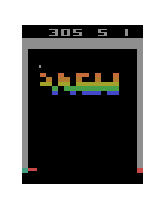
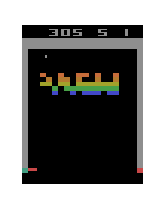
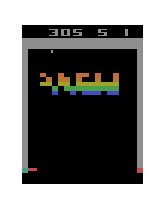
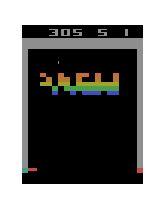
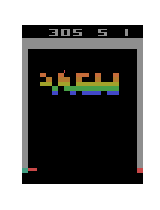
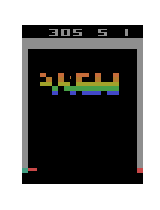
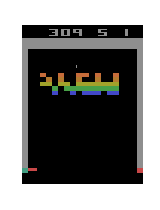
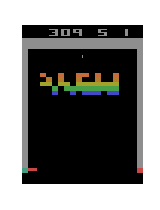
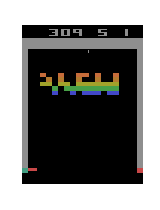
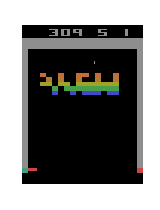
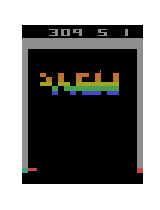
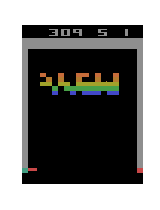
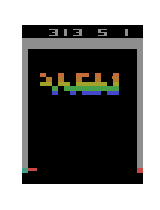
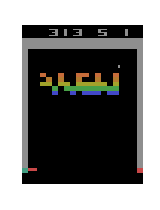
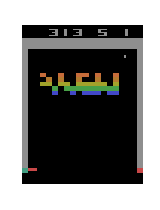
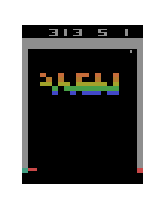
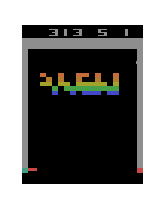
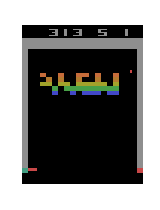
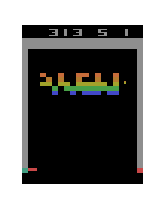
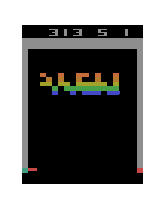
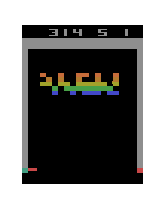
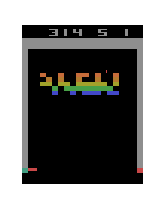
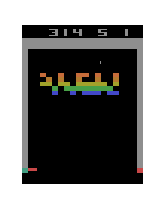
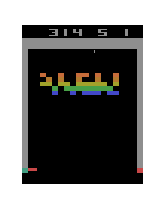
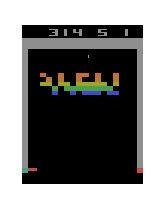
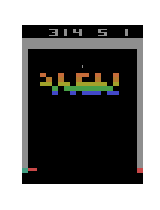
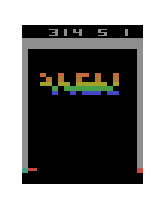
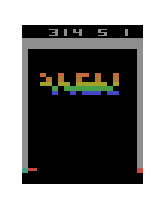
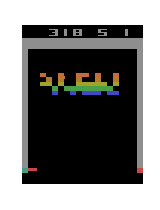
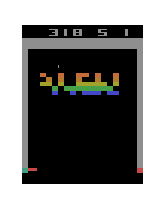
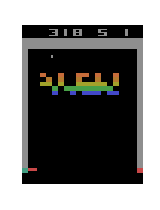
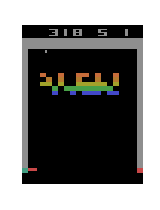
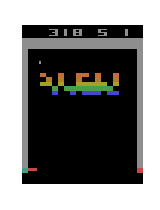
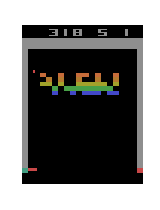
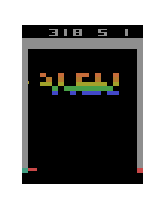
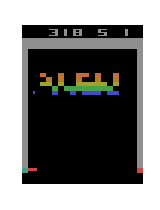
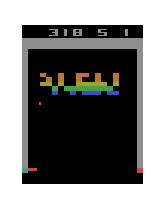
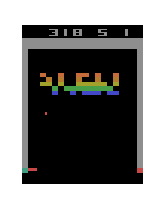
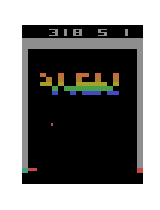
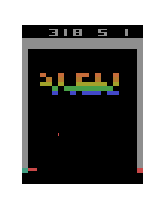
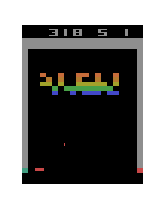
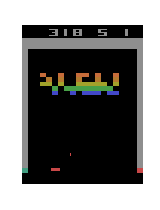
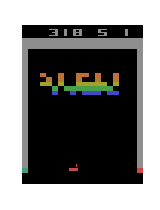
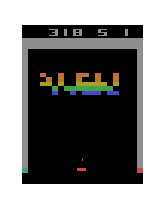
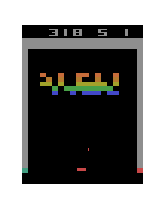
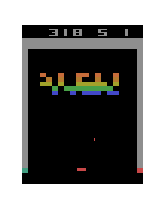
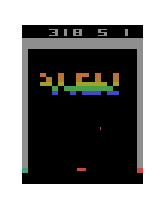
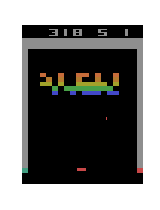
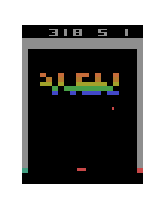
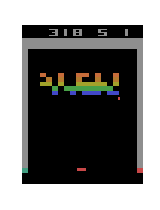
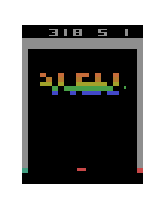
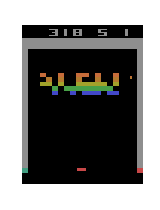
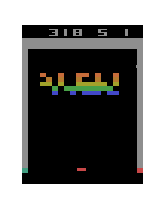
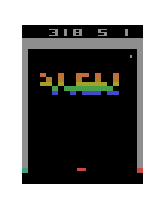
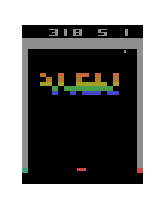
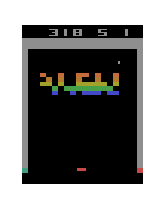
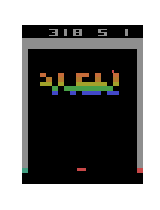
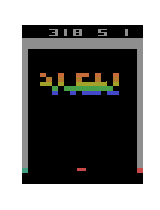
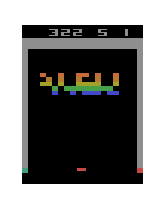
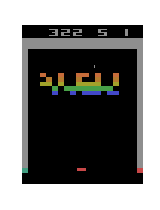
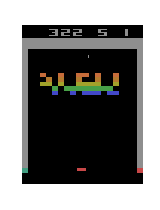
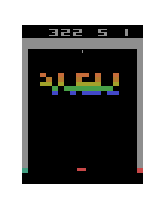
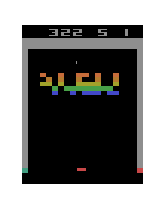
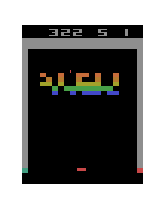
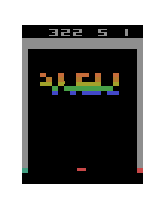
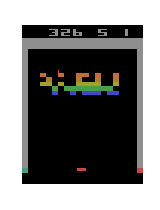
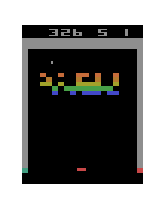
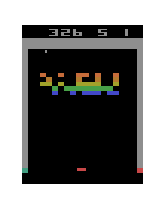
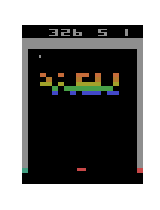
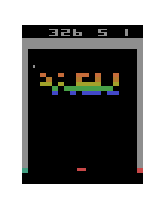
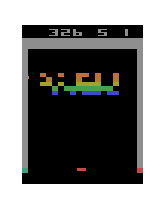
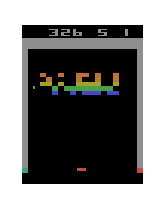
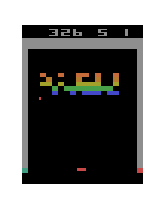
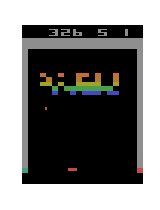
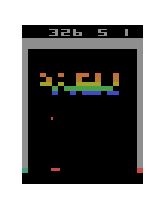
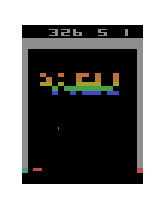
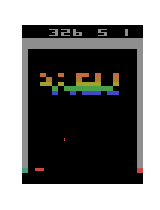
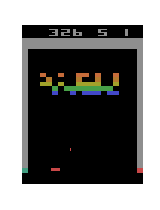
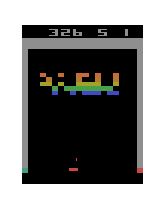
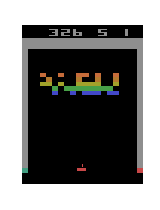
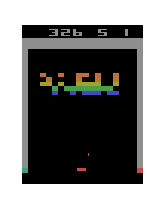
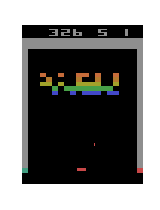
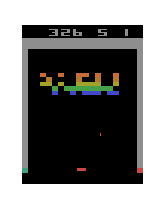
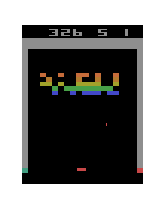
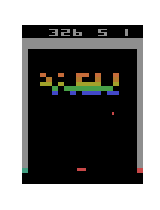
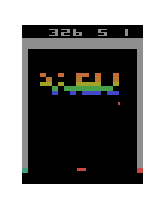
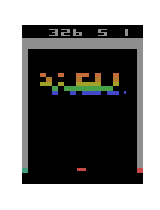
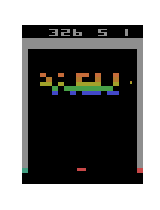
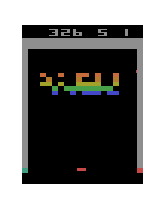
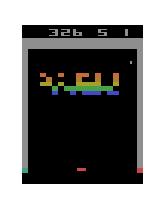
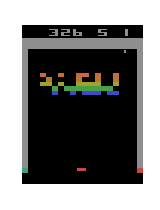
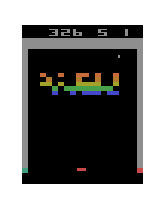
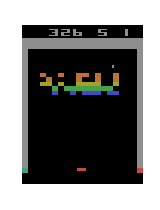
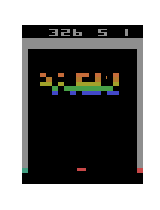
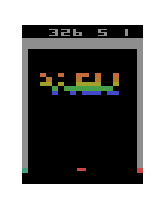
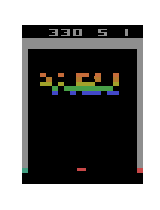
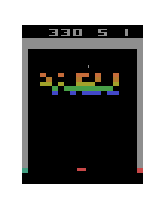
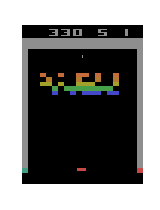
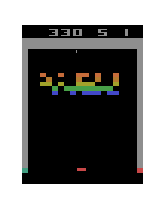
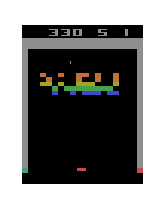
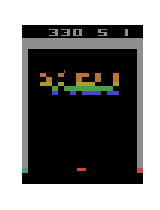
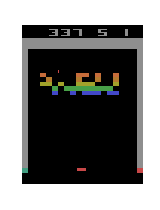
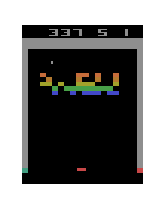
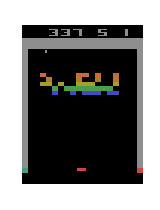
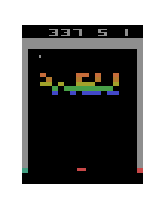
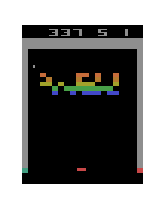
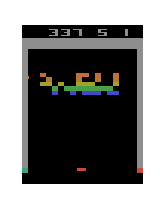
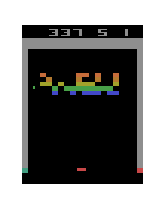
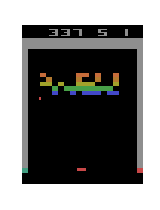
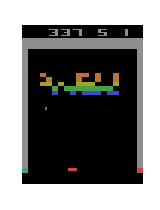
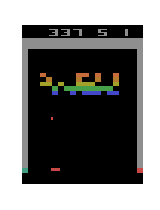
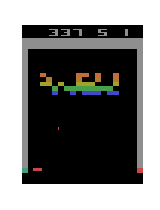
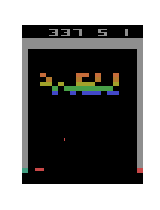
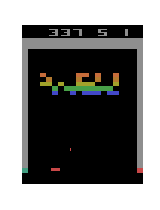
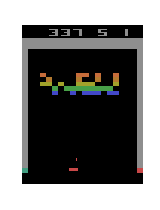
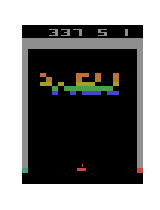
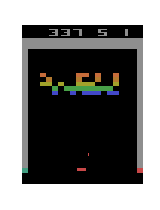
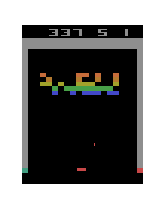
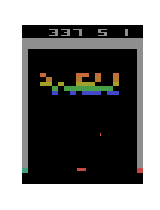
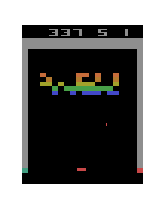
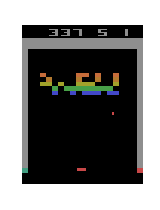
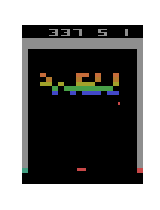
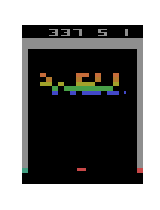
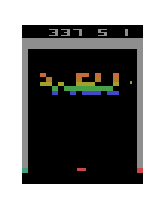
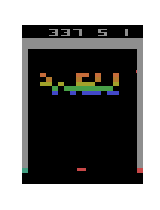
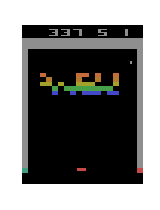
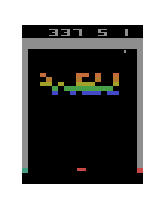
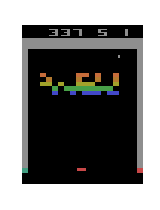
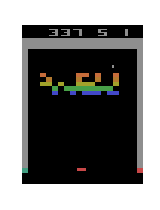
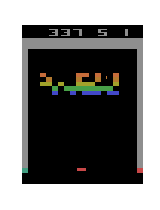
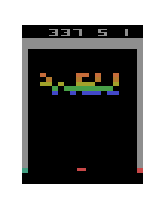
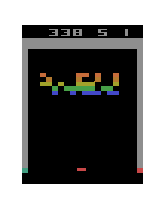
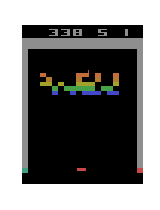
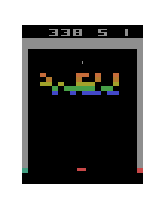
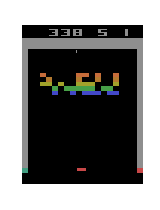
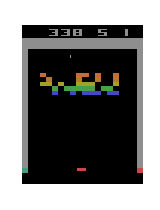
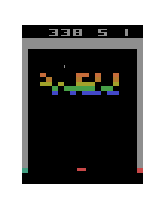
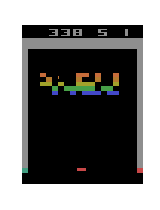
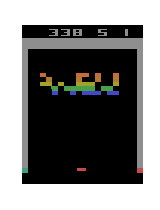
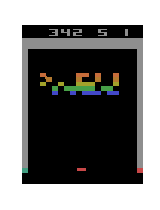
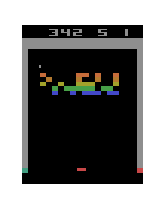
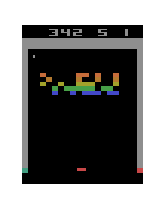
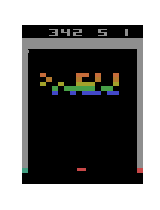
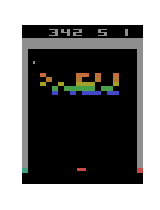
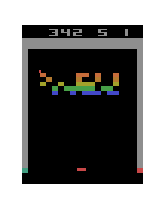
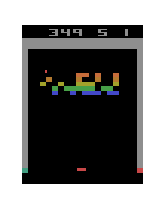
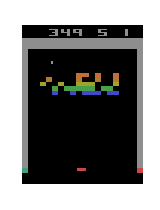
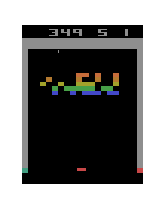
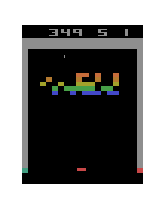
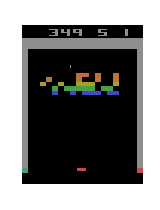
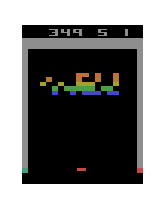
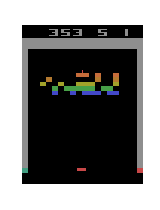
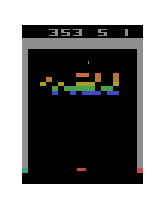
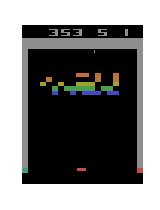
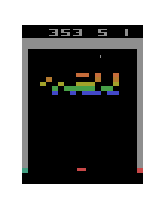
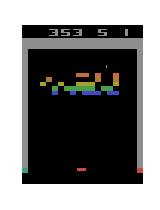
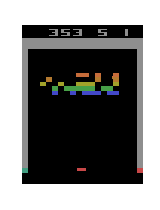
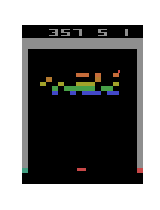
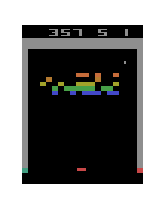
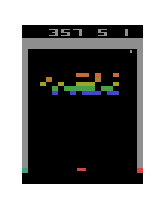
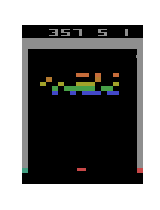
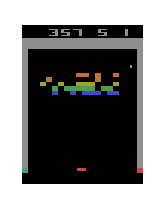
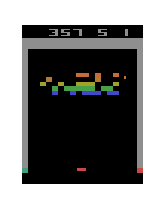
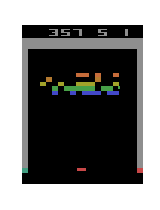
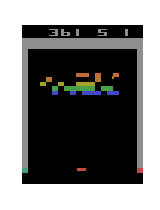
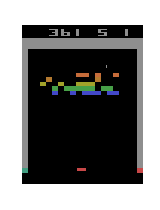
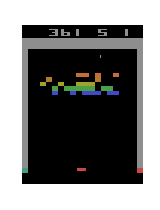
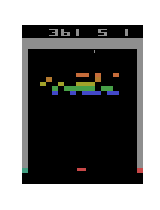
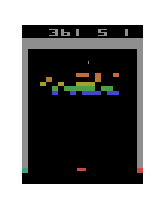
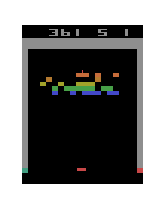
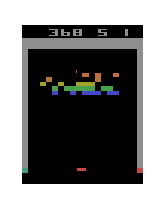
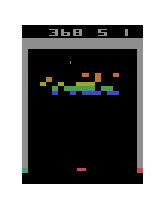
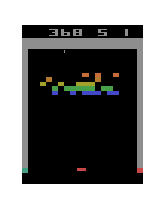
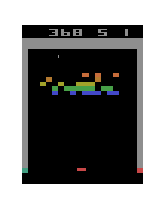
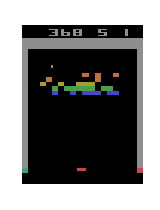
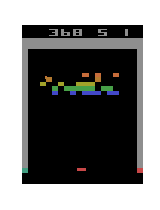
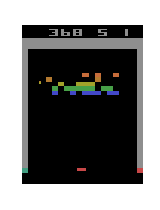
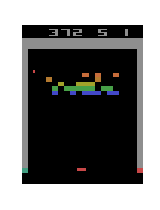
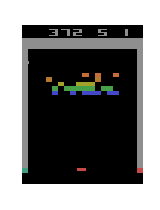
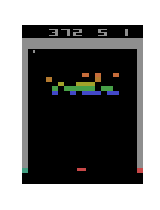
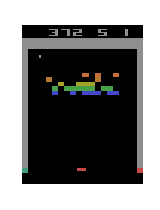
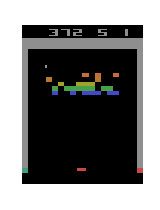
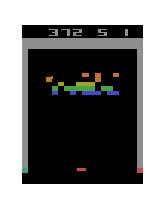
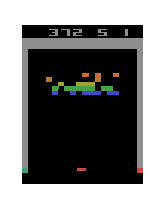
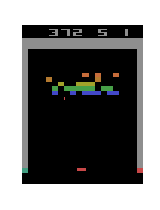
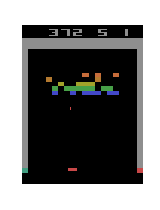
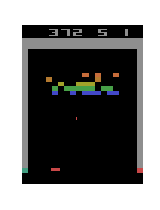
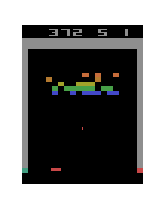
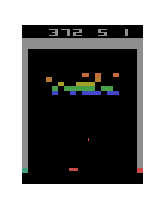
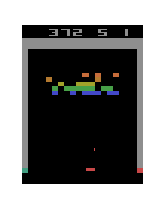
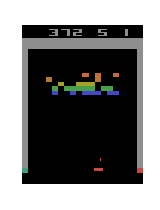
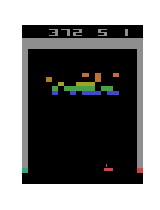
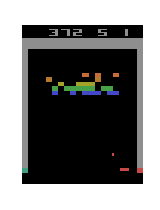
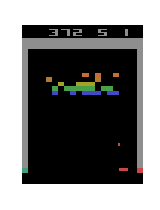
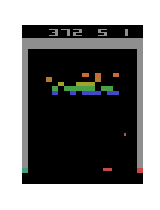
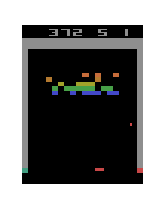
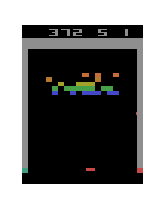
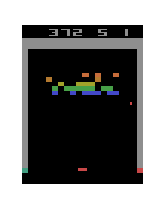
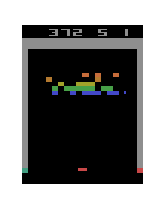
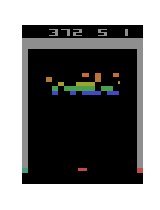
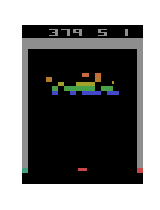
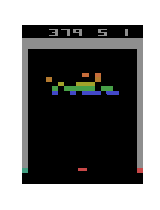
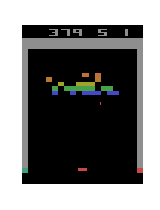
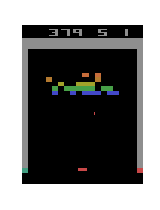
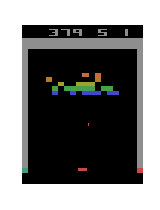
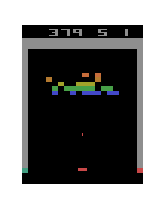
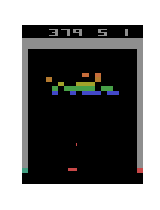
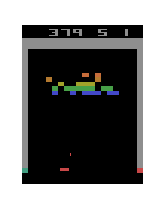
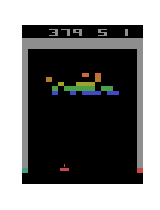
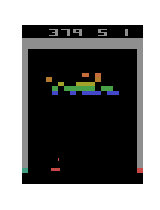
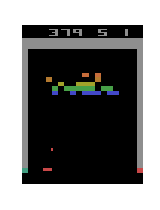
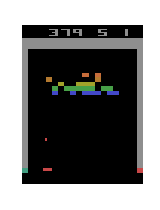
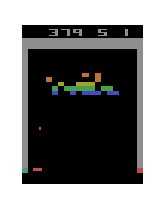
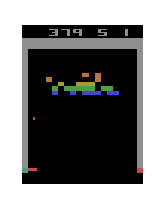
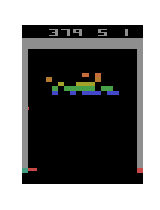
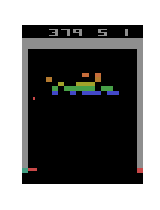
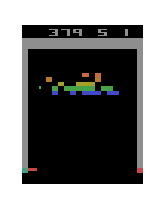
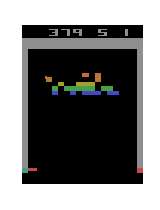
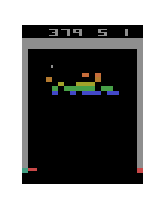
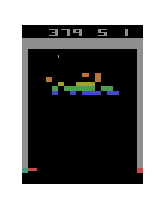
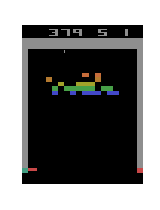
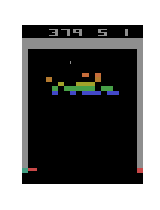
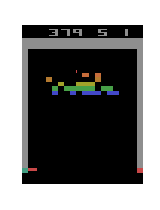
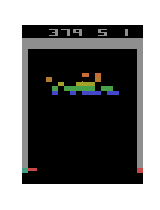
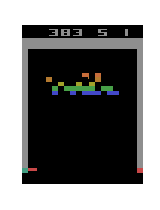
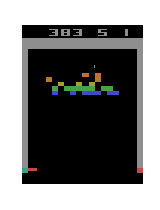
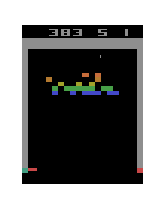
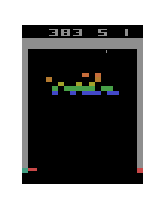
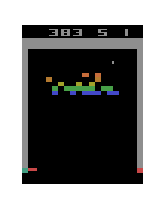
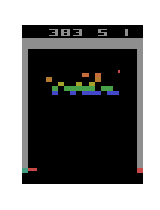
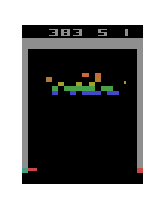
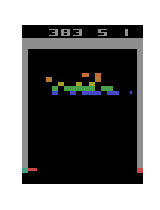
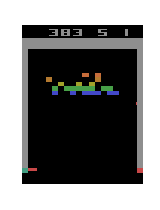
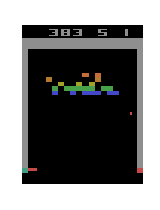
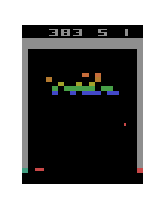
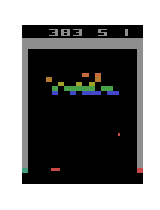
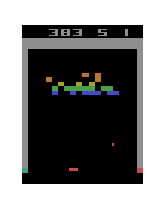
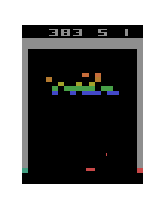
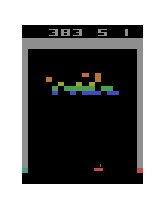
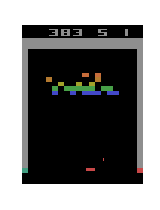
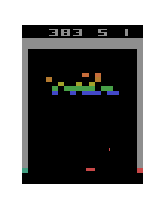
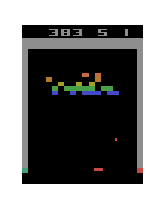
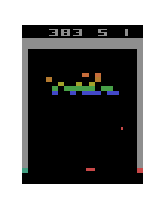
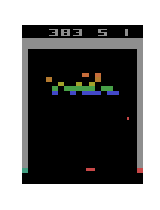
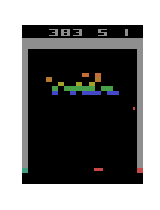
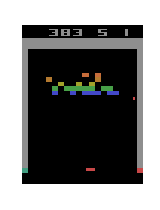
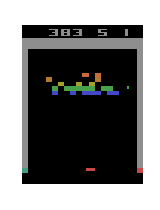
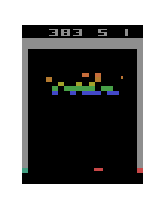
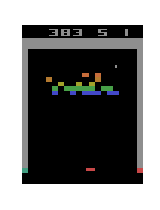
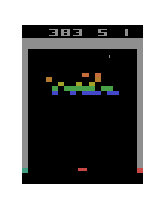
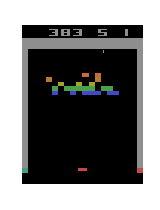
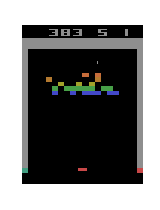
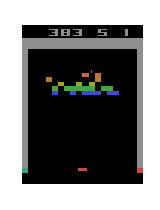
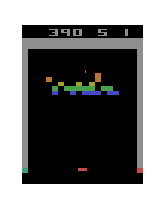
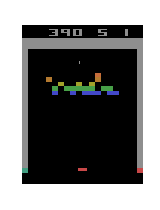
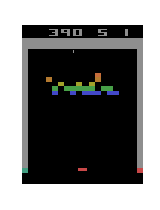
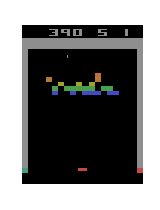
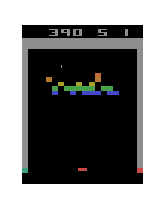
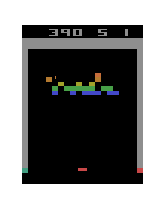
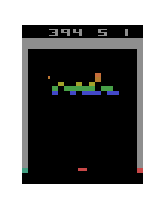
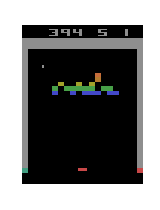
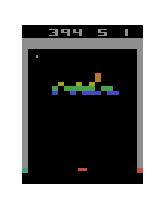
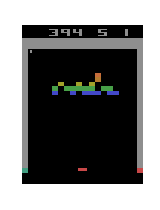
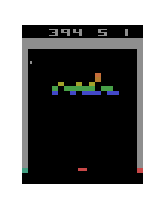
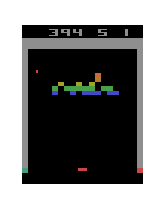
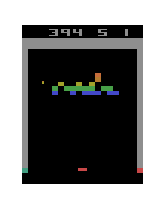
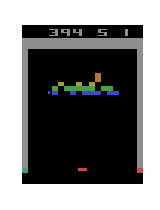
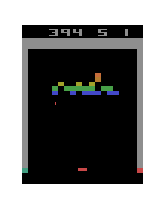
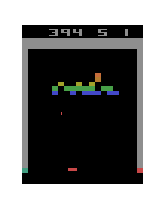
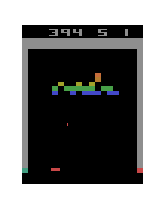
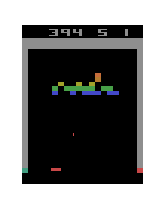
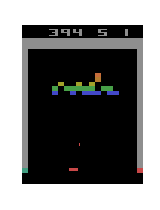
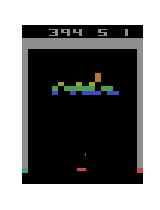
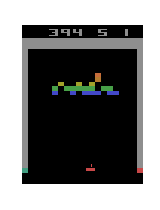
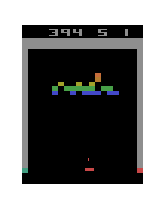
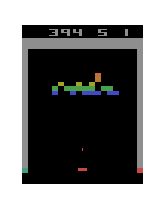
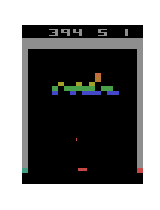
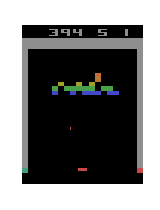
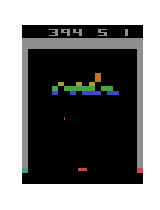
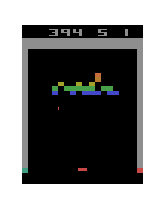
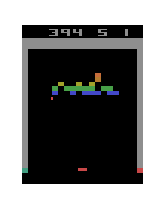
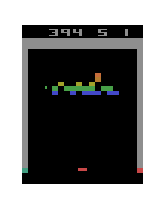
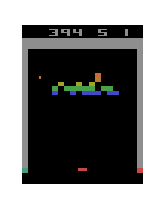
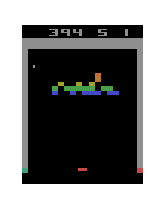
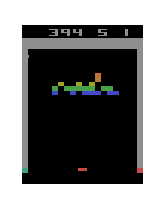
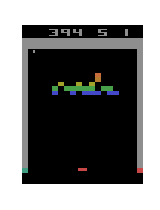
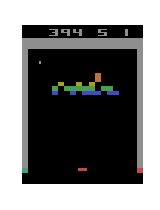
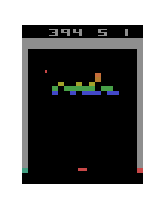
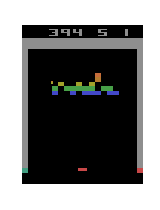
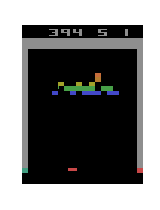
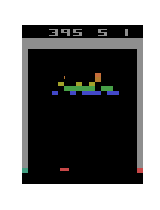
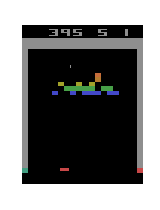
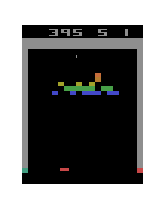
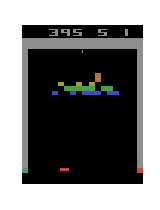
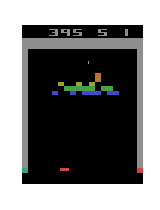
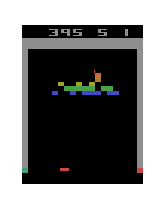
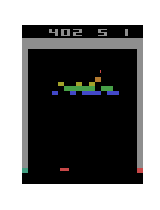
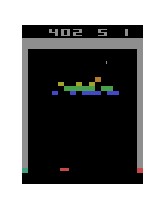
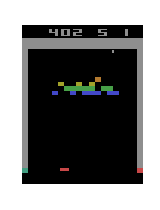
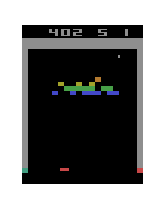
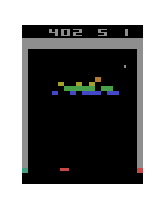
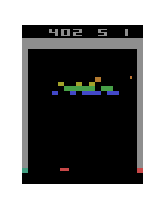
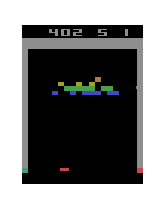
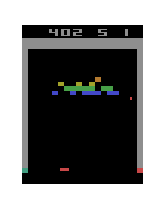
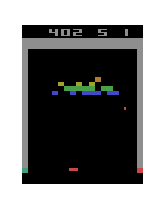
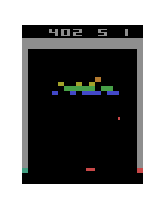
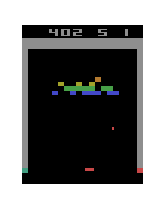
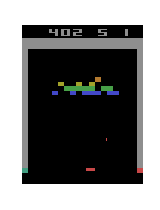
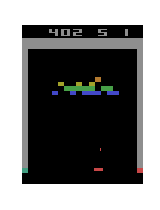
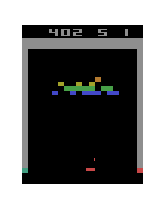
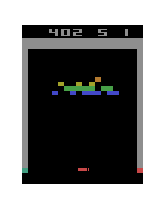
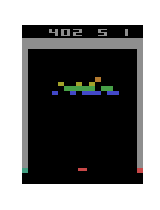
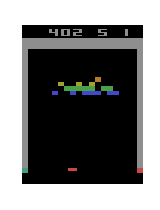
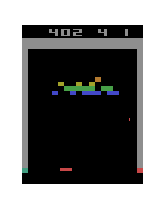

--------End Animation--------




  2%|▏         | 1896/125000 [00:58<49:41, 41.29it/s]

In [50]:
# 実行
breakout_env = Environment()
frames = breakout_env.run()